<a href="https://colab.research.google.com/github/danib08/Reconocimiento-de-Patrones/blob/LinearRegression/Proyecto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.2 MB/s eta 0:00:00


In [740]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from optuna import create_study, logging
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, mean_squared_error, mean_absolute_error
# Imputers
imputer_mode = SimpleImputer(strategy='most_frequent')
imputer_median = SimpleImputer(strategy='median')

# Algoritmos

## Regresión Logística

In [4]:
class OurLogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, lambda_=0):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.lambda_ = lambda_  #parámetro de regularización

    def __add_intercept(self, X):
        # agregar 0s para ver la intersección con y
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid(self, z):
        # función sigmoide
        return 1 / (1 + np.exp(-z))

    def __loss(self, h, y):
        # cross-entropy loss
        # un menos adelante ya que se busca el mínimo (derivada maximiza)
        loss = (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

        # término para regularización L2 (Ridge)
        reg_term = (self.lambda_ / (2 * len(y))) * np.sum(self.w[1:]**2)  # se excluye el intercept
        return loss + reg_term

    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        # inicialización de pesos
        self.w = np.zeros(X.shape[1])

        for i in range(self.num_iter):
            z = np.dot(X, self.w) # producto punto con los pesos
            h = self.__sigmoid(z) # se calculan las probabilidades

            # se calcula el gradiente
            # división por y.size para el promedio
            gradient = np.dot(X.T, (h-y)) / y.size

            # se calcula el término L2 (sin el intercept)
            regularization_term = (self.lambda_ / len(y)) * self.w[1:]

            # actualización de valores
            self.w[0] -= self.lr * gradient[0]
            self.w[1:] -= self.lr * (gradient[1:] + regularization_term)

    def predict_prob(self, X):
        # agregar 0s para mantener coherencia si fit_intercept es TRUE
        if self.fit_intercept:
            X = self.__add_intercept(X)
        return self.__sigmoid(np.dot(X, self.w))

    def predict(self, X, threshold):
        # asigna probabilidad binaria (0/1) según umbral
        return self.predict_prob(X) >= threshold

## K-Nearest Neighbors

In [5]:
class OurKNearest():
    def __init__(self, X_train, y_train, n_neighbors=5, weights='distance', n_classes=2, distance='minkowski', p=0.7):

        # dataset para entrenamiento
        self.X_train = X_train
        self.y_train = y_train

        self.n_neighbors = n_neighbors # K vecinos a usar para la decisión
        self.weights = weights
        self.distance = distance
        self.p = p

        # número de categorías / clases en el dataset
        self.n_classes = n_classes

    # para cada punto en X_test, se calculan las distancias a todos los puntos en X_train,
    # y luego se seleccionan los k vecinos más cercanos.
    # los índices de estos vecinos y sus distancias se guardan en listas
    def kneighbors(self, X_test):
        if self.weights == 'distance':
            return_distance = True

        n_test = X_test.shape[0]
        distances_list = []
        indices_list = []
        batch_size = 500

        # se obtienen las distancias por batches para no recibir oom
        for i in range(0, n_test, batch_size):
            X_test_batch = X_test[i:i+batch_size]

            if self.distance == 'euclidean':
                distances = np.sqrt(np.sum((X_test_batch[:, np.newaxis] - self.X_train)**2, axis=2))
            elif self.distance == 'manhattan':
                distances = np.sum(np.abs(X_test_batch[:, np.newaxis] - self.X_train), axis=2)
            else:
                # default: minkowski
                distances = np.sum(np.abs(X_test_batch[:, np.newaxis] - self.X_train) ** self.p, axis=2) ** (1/self.p)

            # para evitar divisiones por 0, se suma un epsilon pequeño a las distancias
            epsilon = 1e-6
            distances = distances + epsilon

            neigh_ind = np.argsort(distances, axis=1)[:, :self.n_neighbors]

            distances_list.append(distances)
            indices_list.append(neigh_ind)

        distances = np.vstack(distances_list)
        neigh_ind = np.vstack(indices_list)

        return neigh_ind, distances

    def predict(self, X_test, return_prob=True):
        neigh_ind, distances = self.kneighbors(X_test)

        n_test = X_test.shape[0]
        y_pred = np.empty(n_test, dtype=int)
        class_probabilities = np.empty((n_test, self.n_classes), dtype=float)

        for i in range(n_test):
            neighbor_indices = neigh_ind[i, :self.n_neighbors]  # Use at most self.n_neighbors neighbors
            neighbor_distances = distances[i, :self.n_neighbors]

            # pesos
            if self.weights == 'uniform':
                neighbor_weights = np.ones(self.n_neighbors)
            elif self.weights == 'distance':
                neighbor_weights = 1.0 / neighbor_distances

            # se obtienen targets/labels de los vecinos
            neighbor_labels = self.y_train[neighbor_indices]

            # se asegura de que hayan al menos self.n_classes vecinos
            if len(neighbor_labels) < self.n_classes:
                neighbor_indices = neigh_ind[i, :self.n_classes]
                neighbor_labels = self.y_train[neighbor_indices]
                neighbor_weights = neighbor_weights[:self.n_classes]

            # se calculan los pesos por clases
            weighted_counts = np.bincount(neighbor_labels, weights=neighbor_weights)

            # se asigna la clase con mayor peso
            y_pred[i] = np.argmax(weighted_counts)

            # se calculan las probabilides
            if return_prob:
              class_probabilities[i] = weighted_counts / np.sum(neighbor_weights)

        if return_prob:
            return y_pred, class_probabilities
        else:
            return y_pred

## Árboles de Decisión

In [6]:
# Definición de la función para calcular la entropía
def entropy(y):
    unique, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))

# Definición de la función para dividir los datos
def split_data(X, y, feature_index, threshold):
    left_mask = X[:, feature_index] <= threshold
    right_mask = ~left_mask
    return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

class Node:
    def __init__(self, depth=0, max_depth=None, min_info_gain=1e-5, num_classes=2):
        self.depth = depth
        self.max_depth = max_depth
        # indice del feature usado para la división
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None
        self.value = None
        # permite detener la división del árbol cuando el information gain esté debajo de cierto valor
        # esto evita que el árbol crezca demasiado y se overfittee
        self.min_info_gain = min_info_gain
        # esto permite calcular la entropía del dataset solo una vez
        self.cached_entropy = None
        self.labels = None
        self.num_classes = num_classes

    def fit(self, X, y):
        self.labels = y
        unique_classes, class_counts = np.unique(y, return_counts=True)
        self.value = unique_classes[np.argmax(class_counts)]
        # condiciones de parada
        if self.depth == self.max_depth or len(unique_classes) == 1:
            return

        num_features = X.shape[1]
        best_info_gain = -1

        for feature_index in range(num_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                info_gain = self.calculate_info_gain(X, y, feature_index, threshold)

                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    self.feature_index = feature_index
                    self.threshold = threshold

        if best_info_gain < self.min_info_gain:
            return

        if self.feature_index is not None:
            X_left, y_left, X_right, y_right = split_data(X, y, self.feature_index, self.threshold)
            self.left = Node(depth=self.depth + 1, max_depth=self.max_depth, min_info_gain=self.min_info_gain)
            self.left.fit(X_left, y_left)
            self.right = Node(depth=self.depth + 1, max_depth=self.max_depth, min_info_gain=self.min_info_gain)
            self.right.fit(X_right, y_right)

    def calculate_info_gain(self, X, y, feature_index, threshold):
        if self.cached_entropy is None:
            self.cached_entropy = entropy(y)

        X_left_mask = X[:, feature_index] <= threshold
        X_right_mask = ~X_left_mask
        y_left, y_right = y[X_left_mask], y[X_right_mask]

        if len(y_left) == 0 or len(y_right) == 0:
            return 0

        len_y = len(y)
        entropy_left = entropy(y_left)
        entropy_right = entropy(y_right)

        info_gain = (
            self.cached_entropy
            - (len(y_left) / len_y) * entropy_left
            - (len(y_right) / len_y) * entropy_right
        )
        return info_gain

    def predict(self, X):
        if self.feature_index is None:
            return self.value
        elif X[self.feature_index] <= self.threshold:
            return self.left.predict(X)
        else:
            return self.right.predict(X)

    def get_class_probabilities(self, X):
        if self.feature_index is None:
            unique_classes, class_counts = np.unique(self.labels, return_counts=True)
            class_probs = class_counts / len(self.labels)
            return class_probs
        elif X[self.feature_index] <= self.threshold:
            return self.left.get_class_probabilities(X)
        else:
            return self.right.get_class_probabilities(X)

    def predict_prob(self, X):
        class_probs = np.empty((X.shape[0], self.num_classes))

        for i in range(X.shape[0]):
            class_probs[i] = self.get_class_probabilities(X[i])

        return class_probs

## Regresión Lineal

In [330]:
class OurLinearRegression:
    def __init__(self, lr=0.01, num_iter=1000):
        self.lr = lr
        self.num_iter = num_iter
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        # se incializan pesos y bias
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        for _ in range(self.num_iter):
            # predicciones y = w*x + b
            y_pred = np.dot(X, self.weights) + self.bias

            # cálculos de batch gradient descent (según el error)
            dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / num_samples) * np.sum(y_pred - y)

            # se actualizan pesos y bias
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        y_pred = np.dot(X, self.weights) + self.bias
        return y_pred

# Rain in Australia

## Feature Engineering

### Información descriptiva del dataset

Se puede notar que hay variables tanto numéricas como categóricas, y que contienen valores nulos o faltantes.

In [36]:
data = pd.read_csv("https://raw.githubusercontent.com/danib08/Datasets-Patrones/main/weatherAUS.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### Sesgo

Se visualiza que hay un gran sesgo, debido a la gran mayoría de clases 0 (No) en comparación a clases 1 (Yes). Se eliminarán muestras aleatorias de la clase 0 para balancear el dataset.

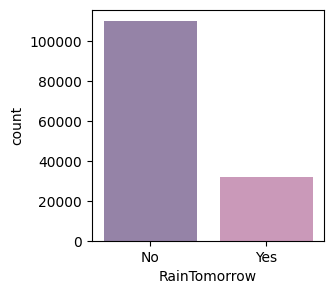

In [37]:
colors= ["#957DAD","#D291BC"]
plt.figure(figsize=(3, 3))
sns.countplot(x=data["RainTomorrow"], palette=colors)
plt.show()

In [38]:
class_0_samples = data[data['RainTomorrow'] == 'No']
class_1_samples = data[data['RainTomorrow'] == 'Yes']

# numero de muestras en cada clase
num_class_0_samples = len(class_0_samples)
num_class_1_samples = len(class_1_samples)

# ratio para balanceo
desired_ratio = 1

# clase 1 se mantiene
desired_num_samples_class_1 = num_class_1_samples

# muestras para clase 2
desired_num_samples_class_0 = desired_ratio * desired_num_samples_class_1
keep_ratio = desired_num_samples_class_0 / num_class_0_samples
class_0_samples_balanced = class_0_samples.sample(frac=keep_ratio, random_state=42)

data = pd.concat([class_0_samples_balanced, class_1_samples])
data = data.sample(frac=1, random_state=42)

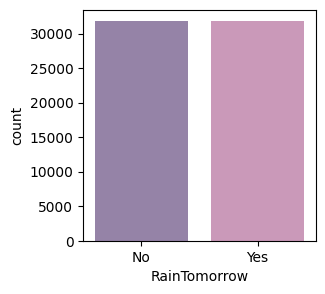

In [39]:
colors= ["#957DAD","#D291BC"]
plt.figure(figsize=(3, 3))
sns.countplot(x=data["RainTomorrow"], palette=colors)
plt.show()

### Matriz de correlación

Las variables cuyo valor de correlación se acerque más a 1, pueden llegar a ser redundantes en el modelo. En este caso, se optó por eliminar las features 'Temp9am' y 'Temp3pm' debido al análisis del heat map y a prueba y error de las mejores combinaciones.

<Axes: >

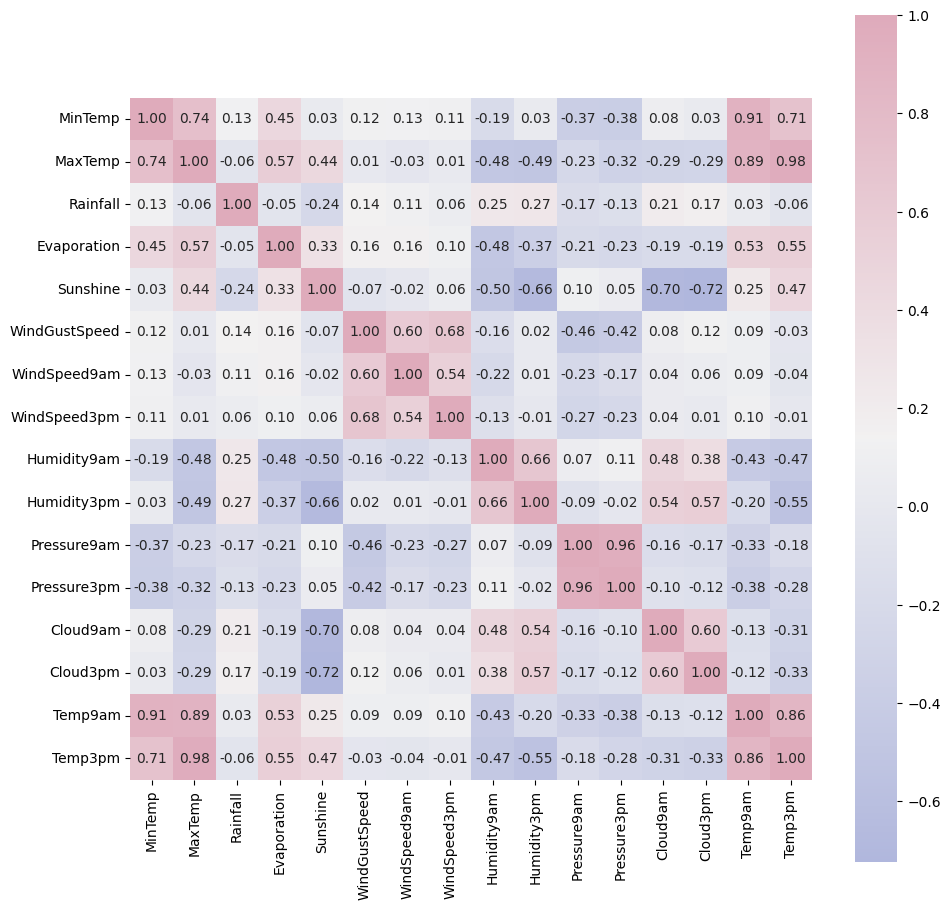

In [40]:
corrmat = data.corr(numeric_only=True)
cmap = sns.diverging_palette(260, -10, s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(11,11))
sns.heatmap(corrmat, cmap=cmap, annot=True, square=True, fmt='.2f')

### Parseando feature "Date" de manera cíclica

Text(0.5, 0, 'seno')

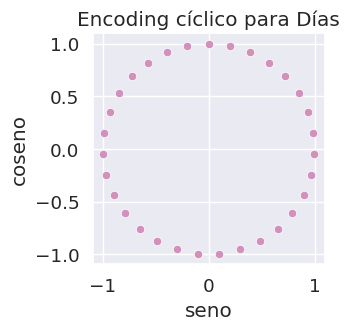

In [ ]:
data['Date']= pd.to_datetime(data["Date"])  # convertir en datetime
data['year'] = data.Date.dt.year # nueva columna extrayendo el año

# encoding para datos con comportamiento cíclico (mes y día)
def cyclic_encoding(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = cyclic_encoding(data, 'month', 12)

data['day'] = data.Date.dt.day
data = cyclic_encoding(data, 'day', 31)

plt.figure(figsize=(3, 3))
cyclic_day = sns.scatterplot(x='day_sin', y='day_cos' ,data=data, color="#D291BC")
cyclic_day.set_title("Encoding cíclico para Días")
cyclic_day.set_ylabel("coseno")
cyclic_day.set_xlabel("seno")

### División en sets de Training / Test


In [ ]:
data['RainTomorrow'] = data['RainTomorrow'].replace({'Yes': 1, 'No': 0})
data['RainTomorrow'] = imputer_mode.fit_transform(data[['RainTomorrow']])

target = data['RainTomorrow']
features = data.drop(['RainTomorrow', 'Date', 'day', 'month', 'Temp9am', 'Temp3pm'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

### Valores nulos - Variables numéricas

In [ ]:
# variables numéricas
nums = (X_train.dtypes == "float64") | (X_train.dtypes == "int64")
numerical = list(nums[nums].index)

# reemplazar nulos por mediana de columna respectiva
X_train[numerical] = imputer_median.fit_transform(X_train[numerical])
X_test[numerical] = imputer_median.transform(X_test[numerical])

# visualizar total de valores nulos
null_counts = X_train[numerical].apply(lambda x: x.isnull().sum())
print(null_counts)

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
year             0
month_sin        0
month_cos        0
day_sin          0
day_cos          0
dtype: int64


### Valores nulos - Variables categóricas

In [ ]:
# variables categóricas
objs = (X_train.dtypes == "object")
categories = list(objs[objs].index)

# reemplazar nulos por moda de columna respectiva
X_train[categories] = imputer_mode.fit_transform(X_train[categories])
X_test[categories] = imputer_mode.transform(X_test[categories])

# visualizar total de valores nulos
null_counts = X_train[categories].apply(lambda x: x.isnull().sum())
print(null_counts)

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
dtype: int64


### Encoding de strings a valores numéricos

In [ ]:
label_encoder = LabelEncoder()

combined_data = pd.concat([X_train, X_test], axis=0)
combined_data[categories] = combined_data[categories].apply(lambda col: label_encoder.fit_transform(col))

X_train = combined_data.iloc[:len(X_train)]
X_test = combined_data.iloc[len(X_train):]

### Normalización

In [ ]:
# reset indices so StandardScaler doesn't mismatch them
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

s_scaler = StandardScaler()

col_names = list(combined_data.columns)

X_train = s_scaler.fit_transform(X_train)
X_test = s_scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=col_names)
X_test = pd.DataFrame(X_test, columns=col_names)

indices_match = X_train.index.equals(y_train.index) and X_test.index.equals(y_test.index)

if indices_match:
    print("Indices match.")
else:
    print("Indices do not match.")

Indices match.


### Análisis de Outliers / Caja de Bigotes


Gracias al diagrama de la Caja de Bigotes de Seaborn, los outliers pueden identificarse como los símbolos de diamantes. Se hará un análisis del rango intercuartil para eliminarlos.

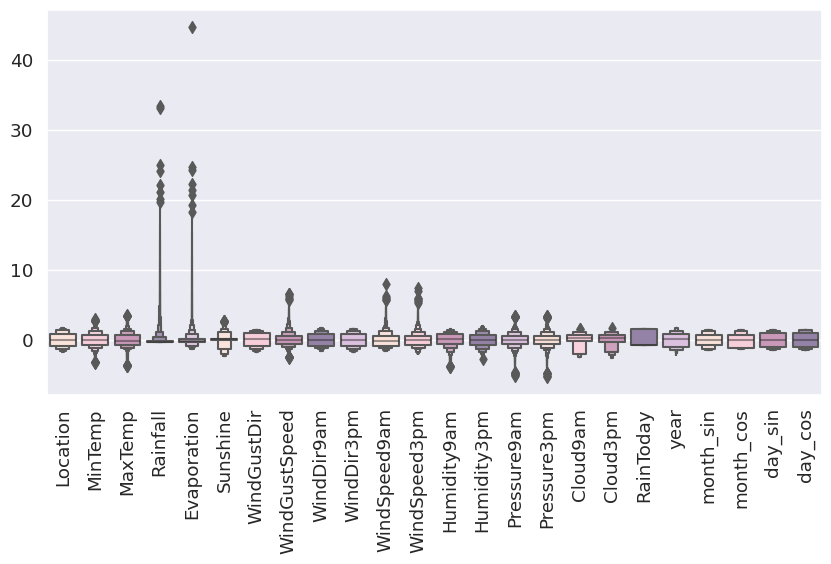

In [ ]:
combined_data = pd.concat([X_train, X_test], axis=0)

colors = ["#FFDFD3", "#FEC8D8", "#D291BC", "#957DAD", "#E0BBE4"]
plt.figure(figsize=(10,5))
sns.boxenplot(data = combined_data, palette = colors)
plt.xticks(rotation=90)
plt.show()

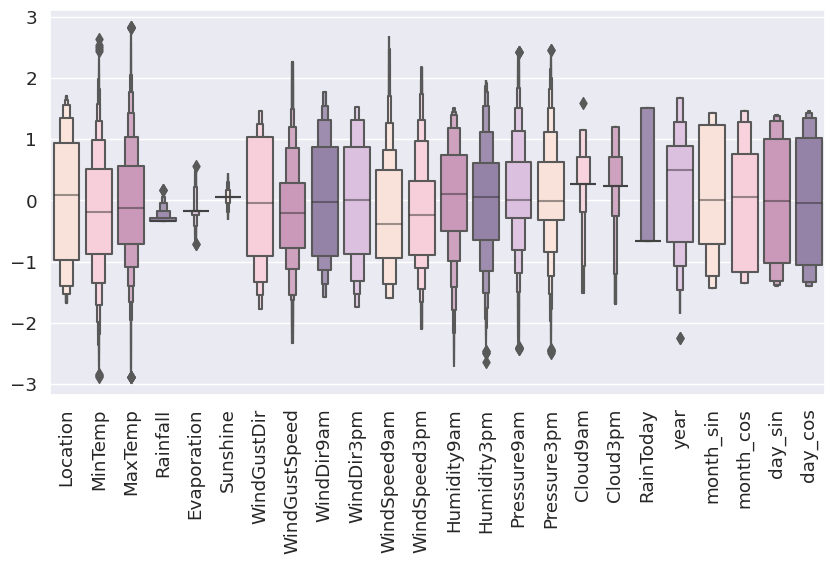

In [ ]:
# funcion para eliminar outliers
def remove_outliers(dataframe, X_train, X_test, y_train, y_test, column, multiplier=1.5):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_fence = Q1 - (IQR * multiplier)
    upper_fence = Q3 + (IQR * multiplier)

    mask_train = (X_train[column] >= lower_fence) & (X_train[column] <= upper_fence)
    mask_test = (X_test[column] >= lower_fence) & (X_test[column] <= upper_fence)

    cleaned_X_train = X_train[mask_train]
    cleaned_X_test = X_test[mask_test]

    cleaned_y_train = y_train[mask_train]
    cleaned_y_test = y_test[mask_test]

    return cleaned_X_train, cleaned_X_test, cleaned_y_train, cleaned_y_test

# features en las cuales se eliminaran outliers
features_to_remove_outliers = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed',
                               'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
                               'Pressure3pm', 'Cloud9am', 'Cloud3pm']

X_train_clean = X_train.copy()
X_test_clean = X_test.copy()
y_train_clean = y_train.copy()
y_test_clean = y_test.copy()

for feature in features_to_remove_outliers:
     X_train_clean, X_test_clean, y_train_clean, y_test_clean = remove_outliers(combined_data, X_train_clean, X_test_clean, y_train_clean, y_test_clean, feature)

combined_data_clean = pd.concat([X_train_clean, X_test_clean], axis=0)
plt.figure(figsize=(10,5))
sns.boxenplot(data = combined_data_clean, palette = colors)
plt.xticks(rotation=90)
plt.show()

## Regresión Logística

### Entrenamiento


Se entrenarán dos modelos, uno con el dataset sin outliers y otro con outliers. Esto para mostrar las diferencias en métricas en ambos casos.

In [ ]:
# con outliers
our_logreg = OurLogisticRegression(0.15, 20000)
our_logreg.fit(X_train, y_train)

# sin outliers
our_logreg_clean = OurLogisticRegression(0.15, 20000)
our_logreg_clean.fit(X_train_clean, y_train_clean)

### Testing

In [ ]:
# con outliers
y_pred_logreg = our_logreg.predict(X_test, threshold=0.5)
y_pred_train_logreg = our_logreg.predict(X_train, threshold=0.5)
y_prob_logreg = our_logreg.predict_prob(X_test)

# sin outliers
y_pred_logreg_clean = our_logreg_clean.predict(X_test_clean, threshold=0.5)
y_pred_train_logreg_clean = our_logreg_clean.predict(X_train_clean, threshold=0.5)
y_prob_logreg_clean = our_logreg_clean.predict_prob(X_test_clean)

### Métricas y Análisis Inicial

Para ambos casos, no se observa overfitting ni underfitting, ya que los valores de accuracy, precision, recall y F1 score se mantienen en rangos sumamente similares tanto en el entrenamiento como e el testeo.

Aunque, es notable que al utilizar el dataset con outliers, se obtienen mejores métricas. Esto se puede explicar con la posibilidad de que los outliers sean datos sí atípicos, pero igualmente importantes para el modelo. Es decir, son mediciones que aún así son válidas y deben tomarse en cuenta.

Para este modelo, se considera que los Falsos Negativos deben minimizarse, ya que es más crítico predecir que no va a llover cuando en realidad sí lo hace. En otras palabras, se quieren minimizar los errores de Tipo 2 por sobre los Tipo 1. Sin embargo, los errores Tipo 1 también son importantes. Al observar la métrica de F1, se obtiene un balance muy bueno entre precision y recall, lo que es ideal.

In [ ]:
# accuracy, precision, recall, f1

# con outliers
our_logreg_train_accuracy = accuracy_score(y_train, y_pred_train_logreg)
our_logreg_train_precision = precision_score(y_train, y_pred_train_logreg)
our_logreg_train_recall = recall_score(y_train, y_pred_train_logreg)
our_logreg_train_f1 = f1_score(y_train, y_pred_train_logreg)

our_logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
our_logreg_precision = precision_score(y_test, y_pred_logreg)
our_logreg_recall = recall_score(y_test, y_pred_logreg)
our_logreg_f1 = f1_score(y_test, y_pred_logreg)

# sin outliers
our_logreg_train_accuracy_clean = accuracy_score(y_train_clean, y_pred_train_logreg_clean)
our_logreg_train_precision_clean = precision_score(y_train_clean, y_pred_train_logreg_clean)
our_logreg_train_recall_clean = recall_score(y_train_clean, y_pred_train_logreg_clean)
our_logreg_train_f1_clean = f1_score(y_train_clean, y_pred_train_logreg_clean)

our_logreg_accuracy_clean = accuracy_score(y_test_clean, y_pred_logreg_clean)
our_logreg_precision_clean = precision_score(y_test_clean, y_pred_logreg_clean)
our_logreg_recall_clean = recall_score(y_test_clean, y_pred_logreg_clean)
our_logreg_f1_clean = f1_score(y_test_clean, y_pred_logreg_clean)

print("----- DATASET CON OUTLIERS -----")
print('Our training accuracy:  {0:0.8f}'. format(our_logreg_train_accuracy))
print('Our training precision: {0:0.8f}'. format(our_logreg_train_precision))
print('Our training recall:    {0:0.8f}'. format(our_logreg_train_recall))
print('Our training F1:        {0:0.8f}'. format(our_logreg_train_f1))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_logreg_accuracy))
print('Our test precision: {0:0.8f}'. format(our_logreg_precision))
print('Our test recall:    {0:0.8f}'. format(our_logreg_recall))
print('Our test F1:        {0:0.8f}'. format(our_logreg_f1))
print("\n")

print("----- DATASET SIN OUTLIERS -----")
print('Our training accuracy:  {0:0.8f}'. format(our_logreg_train_accuracy_clean))
print('Our training precision: {0:0.8f}'. format(our_logreg_train_precision_clean))
print('Our training recall:    {0:0.8f}'. format(our_logreg_train_recall_clean))
print('Our training F1:        {0:0.8f}'. format(our_logreg_train_f1_clean))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_logreg_accuracy_clean))
print('Our test precision: {0:0.8f}'. format(our_logreg_precision_clean))
print('Our test recall:    {0:0.8f}'. format(our_logreg_recall_clean))
print('Our test F1:        {0:0.8f}'. format(our_logreg_f1_clean))

----- DATASET CON OUTLIERS -----
Our training accuracy:  0.77639097
Our training precision: 0.78147962
Our training recall:    0.76736578
Our training F1:        0.77435839


Our test accuracy:  0.78057197
Our test precision: 0.78421610
Our test recall:    0.77412946
Our test F1:        0.77914014


----- DATASET SIN OUTLIERS -----
Our training accuracy:  0.74041454
Our training precision: 0.73458529
Our training recall:    0.67851980
Our training F1:        0.70544034


Our test accuracy:  0.74212297
Our test precision: 0.73395150
Our test recall:    0.68645764
Our test F1:        0.70941055


La matriz de confusión para el dataset con outliers muestra que la cantidad de Falsos Negativos (FN), es decir, la clasificación de observaciones reales de que va a llover, es mucho menor a la cantidad de VN. Lo mismo se cumple para los Falsos Positivos. Estos buenos resultados se dan debido a la eliminación del sesgo en el dataset, ya que el modelo logra discernir relativamente bien entre ambas clases.

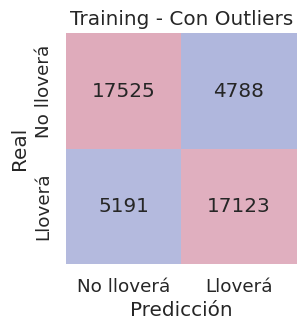

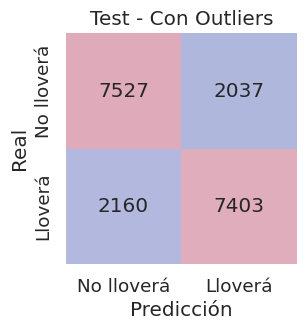

In [ ]:
# confusion matrix
cm_train = confusion_matrix(y_train, y_pred_train_logreg)
cm_test = confusion_matrix(y_test, y_pred_logreg)

class_names = ["No lloverá", "Lloverá"]

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_train, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Training - Con Outliers')
plt.show()

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_test, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Test - Con Outliers')
plt.show()

El AUC da un valor bastante alto, lo que implica que el modelo es bueno en su capacidad de separar los eventos de lluvia de los eventos sin lluvia. Un AUC = 1 es el ideal, por lo que entonces el valor obtenido es bastante bueno.

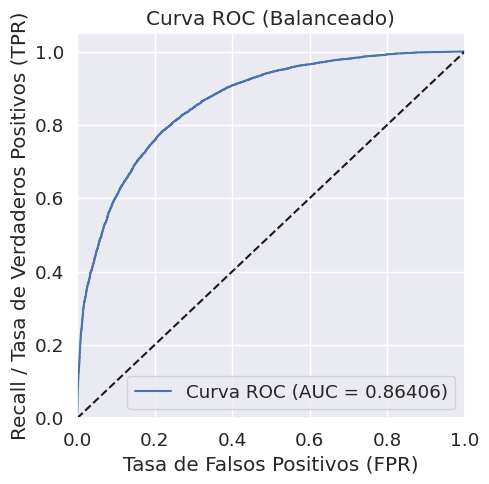

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC (Balanceado)')
plt.legend(loc="lower right")
plt.show()

### Ajuste de Hiperparámetros

In [ ]:
def objective(trial):
    lr = trial.suggest_float('lr', 0.10, 0.5, log=True)
    num_iter = trial.suggest_int('num_iter', 20000, 40000)

    model = OurLogisticRegression(lr=lr, num_iter=num_iter)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test, threshold=0.5)

    # métrica a optimizar
    F1 = f1_score(y_test, y_pred)

    return F1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

best_params = study.best_params
best_recall_score = study.best_value

[I 2023-10-02 19:57:16,341] A new study created in memory with name: no-name-7cbceb0e-77fe-433a-b525-784f13005a64
[I 2023-10-02 19:59:01,909] Trial 0 finished with value: 0.7791401357680368 and parameters: {'lr': 0.31882347121900806, 'num_iter': 34885}. Best is trial 0 with value: 0.7791401357680368.
[I 2023-10-02 20:01:14,515] Trial 1 finished with value: 0.7791401357680368 and parameters: {'lr': 0.11850321542949332, 'num_iter': 38940}. Best is trial 0 with value: 0.7791401357680368.
[I 2023-10-02 20:02:32,341] Trial 2 finished with value: 0.7791401357680368 and parameters: {'lr': 0.40394621169672584, 'num_iter': 28654}. Best is trial 0 with value: 0.7791401357680368.
[I 2023-10-02 20:04:15,458] Trial 3 finished with value: 0.7791401357680368 and parameters: {'lr': 0.15170465021452506, 'num_iter': 34301}. Best is trial 0 with value: 0.7791401357680368.
[I 2023-10-02 20:05:19,041] Trial 4 finished with value: 0.7791401357680368 and parameters: {'lr': 0.15124814471257825, 'num_iter': 22

### Resultados finales - Ajuste de Umbral

Por último, se probarán distintos umbrales para mejorar el F1 score y por lo tanto el recall.

In [ ]:
our_logreg = OurLogisticRegression(best_params['lr'], best_params['num_iter'])
our_logreg.fit(X_train, y_train)
y_prob_logreg = our_logreg.predict_prob(X_test)

# umbrales a probar
thresholds = np.linspace(0, 1, 101)
best_threshold = 0
best_f1 = 0

for threshold in thresholds:
    y_pred = (y_prob_logreg > threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

y_pred_best = (y_prob_logreg > best_threshold).astype(int)

# accuracy, precision, recall, f1
our_logreg_reg_accuracy = accuracy_score(y_test, y_pred_best)
our_logreg_reg_precision = precision_score(y_test, y_pred_best)
our_logreg_reg_recall = recall_score(y_test, y_pred_best)
our_logreg_reg_f1 = f1_score(y_test, y_pred_best)

print('Our accuracy:  {0:0.8f}'. format(our_logreg_reg_accuracy))
print('Our precision: {0:0.8f}'. format(our_logreg_reg_precision))
print('Our recall:    {0:0.8f}'. format(our_logreg_reg_recall))
print('Our F1:        {0:0.8f}'. format(our_logreg_reg_f1))

Our accuracy:  0.76969729
Our precision: 0.72524017
Our recall:    0.86834675
Our F1:        0.79036787


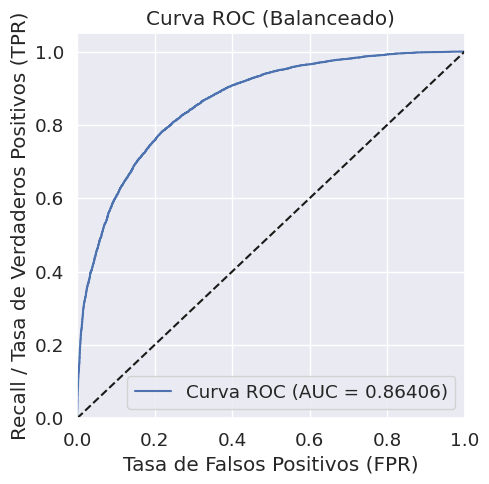

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC (Balanceado)')
plt.legend(loc="lower right")
plt.show()

### Comparación con sklearn

In [ ]:
skleran_logreg = LogisticRegression(random_state=42)
skleran_logreg.fit(X_train, y_train)
skleran_logreg_pred = skleran_logreg.predict(X_test)
sklearn_y_proba = skleran_logreg.predict_proba(X_test)[:, 1]

sklearn_logreg_accuracy = accuracy_score(y_test, skleran_logreg_pred)
sklearn_logreg_precision = precision_score(y_test, skleran_logreg_pred)
sklearn_logreg_recall = recall_score(y_test, skleran_logreg_pred)
sklearn_logreg_f1 = f1_score(y_test, skleran_logreg_pred)

print('sklearn accuracy:  {0:0.8f}'. format(sklearn_logreg_accuracy))
print('sklearn precision: {0:0.8f}'. format(sklearn_logreg_precision))
print('sklearn recall:    {0:0.8f}'. format(sklearn_logreg_recall))
print('sklearn F1:        {0:0.8f}'. format(sklearn_logreg_f1))

sklearn accuracy:  0.78062425
sklearn precision: 0.78423896
sklearn recall:    0.77423403
sklearn F1:        0.77920438


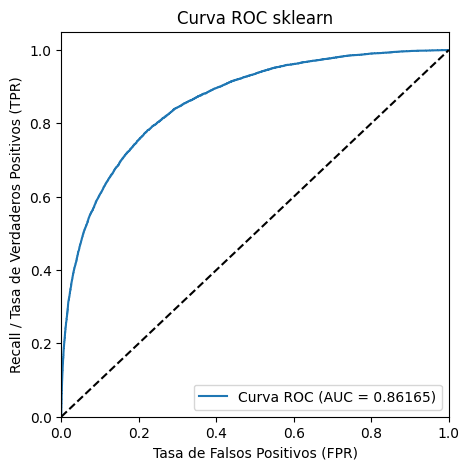

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, sklearn_y_proba)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC sklearn')
plt.legend(loc="lower right")
plt.show()

## K-Nearest Neighbors

### Conversión a NumPy arrays

Para este algoritmo y el de árboles de decisión, se entrenará únicamente con el dataset con outliers, ya que anteriormente se comprobó que este brinda resultados mejores.
Se debe cambiar de DataFrame a numpy array, debido a que es el tipo de dato que manejan de buena manera OurKNearest y OurDecisionTree.

Para KNN, se utiliza el dataset sin outliers debido a que si se usa el dataset con outliers, sufrimos de insuficiencia de memoria.

In [ ]:
X_test_np = X_test_clean.to_numpy()
y_test_np = y_test_clean.to_numpy()

X_train_np = X_train_clean.to_numpy()
y_train_np = y_train_clean.to_numpy()

### Entrenamiento

In [ ]:
our_knn = OurKNearest(X_train_np, y_train_np, n_neighbors=5, weights='distance', n_classes=2, distance='minkowski', p=0.8)

### Testing

In [ ]:
y_pred_knn_train = our_knn.predict(X_train_np, return_prob=False)
y_pred_knn, y_prob_knn = our_knn.predict(X_test_np)

### Métricas y Análisis Inicial

Con las métricas obtenidas, se observa que hay un poco de overfitting debido a que las métricas del testing no son tan buenas como las de training.

In [ ]:
our_knn_accuracy_train = accuracy_score(y_train_np, y_pred_knn_train)
our_knn_precision_train = precision_score(y_train_np, y_pred_knn_train)
our_knn_recall_train = recall_score(y_train_np, y_pred_knn_train)
our_knn_f1_train = f1_score(y_train_np, y_pred_knn_train)

our_knn_accuracy = accuracy_score(y_test_np, y_pred_knn)
our_knn_precision = precision_score(y_test_np, y_pred_knn)
our_knn_recall = recall_score(y_test_np, y_pred_knn)
our_knn_f1 = f1_score(y_test_np, y_pred_knn)


print('Our train accuracy:  {0:0.8f}'. format(our_knn_accuracy_train))
print('Our train precision: {0:0.8f}'. format(our_knn_precision_train))
print('Our train recall:    {0:0.8f}'. format(our_knn_recall_train))
print('Our train F1:        {0:0.8f}'. format(our_knn_f1_train))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_knn_accuracy))
print('Our test precision: {0:0.8f}'. format(our_knn_precision))
print('Our test recall:    {0:0.8f}'. format(our_knn_recall))
print('Our test F1:        {0:0.8f}'. format(our_knn_f1))

Our train accuracy:  0.82100523
Our train precision: 0.82750583
Our train recall:    0.76973114
Our train F1:        0.79757358


Our test accuracy:  0.73569899
Our test precision: 0.73553412
Our test recall:    0.66144096
Our test F1:        0.69652266


Con la matriz de confusión, se muestra que el modelo logra clasificar correctamente la mayoría de los datos. Igualmente posee FN y FP, pero en una medida mucho menor que sus contrapartes verdaderos.

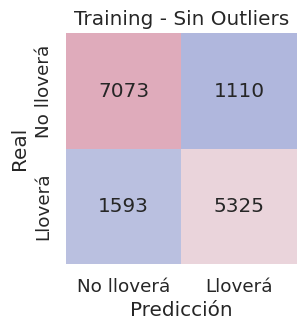

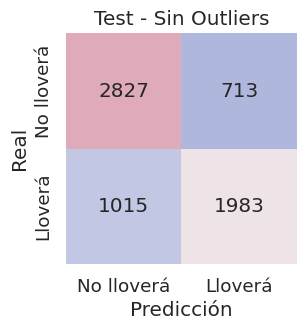

In [ ]:
# confusion matrix
cm_train = confusion_matrix(y_train_np, y_pred_knn_train)
cm_test = confusion_matrix(y_test_np, y_pred_knn)

class_names = ["No lloverá", "Lloverá"]

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_train, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Training - Sin Outliers')
plt.show()

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_test, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Test - Sin Outliers')
plt.show()

La gráfica ROC y el valor de AUC muestran que este modelo de KNN no es uno muy bueno, y tiene problemas para clasificar y diferenciar entre ambas clases. Esto puede ser debido a que KNN es uno de fuerza bruta, y no tan especializado como lo es la regresión logística.

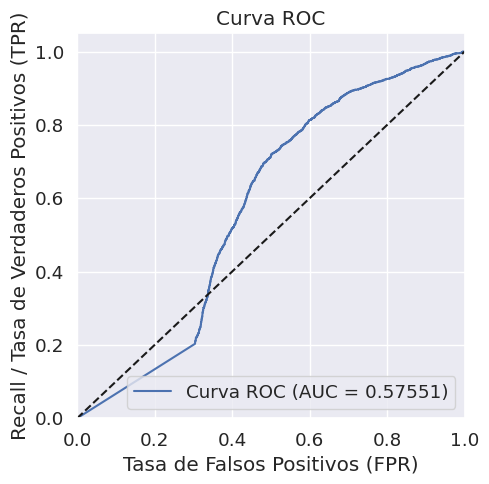

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_np, y_prob_knn[:, 1])
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Ajuste de Hiperparámetro (k)

In [ ]:
def objective(trial):
    k = trial.suggest_int('k', 5, 50)

    model = OurKNearest(X_train_np, y_train_np, n_neighbors=k, weights='distance', n_classes=2, distance='minkowski', p=0.8)

    y_pred = our_knn.predict(X_test_np, return_prob=False)

    # métrica a optimizar
    F1 = f1_score(y_test_np, y_pred)

    return F1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
best_recall_score = study.best_value

[I 2023-10-03 07:21:52,567] A new study created in memory with name: no-name-a11a182a-4cd4-4dc4-8390-e73293b92656
[I 2023-10-03 07:24:04,827] Trial 0 finished with value: 0.6965226554267651 and parameters: {'k': 16}. Best is trial 0 with value: 0.6965226554267651.
[I 2023-10-03 07:26:22,697] Trial 1 finished with value: 0.6965226554267651 and parameters: {'k': 24}. Best is trial 0 with value: 0.6965226554267651.
[I 2023-10-03 07:28:19,537] Trial 2 finished with value: 0.6965226554267651 and parameters: {'k': 15}. Best is trial 0 with value: 0.6965226554267651.
[I 2023-10-03 07:29:55,523] Trial 3 finished with value: 0.6965226554267651 and parameters: {'k': 45}. Best is trial 0 with value: 0.6965226554267651.
[I 2023-10-03 07:31:32,711] Trial 4 finished with value: 0.6965226554267651 and parameters: {'k': 33}. Best is trial 0 with value: 0.6965226554267651.
[I 2023-10-03 07:33:14,228] Trial 5 finished with value: 0.6965226554267651 and parameters: {'k': 22}. Best is trial 0 with value: 

### Resultados finales

Gracias al ajuste del parámetro k, se logró una mejoría bastante considerable en las métricas, así como eliminar el overfitting.
El AUC ahora es un muy buen valor, lo que implica que escoger un valor bueno de k neighbors es crucial para este algoritmo.

In [ ]:
our_knn = OurKNearest(X_train_np, y_train_np, n_neighbors=best_params['k'], weights='distance', n_classes=2, distance='minkowski', p=0.8)

y_pred_knn_train = our_knn.predict(X_train_np, return_prob=False)
y_pred_knn, y_prob_knn = our_knn.predict(X_test_np)

In [ ]:
our_knn_accuracy_train = accuracy_score(y_train_np, y_pred_knn_train)
our_knn_precision_train = precision_score(y_train_np, y_pred_knn_train)
our_knn_recall_train = recall_score(y_train_np, y_pred_knn_train)
our_knn_f1_train = f1_score(y_train_np, y_pred_knn_train)

our_knn_accuracy = accuracy_score(y_test_np, y_pred_knn)
our_knn_precision = precision_score(y_test_np, y_pred_knn)
our_knn_recall = recall_score(y_test_np, y_pred_knn)
our_knn_f1 = f1_score(y_test_np, y_pred_knn)


print('Our train accuracy:  {0:0.8f}'. format(our_knn_accuracy_train))
print('Our train precision: {0:0.8f}'. format(our_knn_precision_train))
print('Our train recall:    {0:0.8f}'. format(our_knn_recall_train))
print('Our train F1:        {0:0.8f}'. format(our_knn_f1_train))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_knn_accuracy))
print('Our test precision: {0:0.8f}'. format(our_knn_precision))
print('Our test recall:    {0:0.8f}'. format(our_knn_recall))
print('Our test F1:        {0:0.8f}'. format(our_knn_f1))

Our train accuracy:  0.77345871
Our train precision: 0.79480695
Our train recall:    0.68141081
Our train F1:        0.73375360


Our test accuracy:  0.74793515
Our test precision: 0.76849642
Our test recall:    0.64442962
Our test F1:        0.70101597


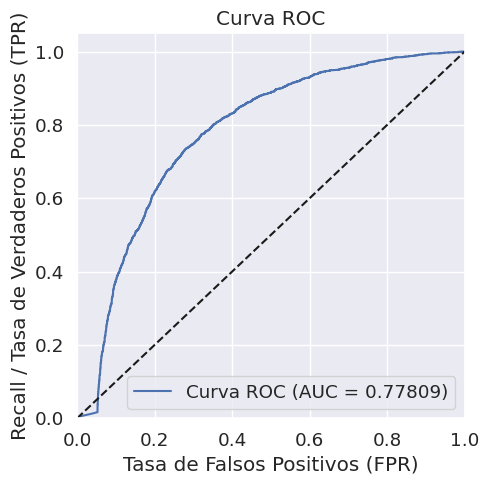

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_np, y_prob_knn[:, 1])
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Comparación con sklearn

In [ ]:
sklearn_knn = KNeighborsClassifier(n_neighbors=best_params['k'], weights='distance')
sklearn_knn.fit(X_train_np, y_train_np)
skleran_knn_pred = sklearn_knn.predict(X_test_np)
sklearn_knn_proba = sklearn_knn.predict_proba(X_test_np)[:, 1]

sklearn_knn_accuracy = accuracy_score(y_test_np, skleran_knn_pred)
sklearn_knn_precision = precision_score(y_test_np, skleran_knn_pred)
sklearn_knn_recall = recall_score(y_test_np, skleran_knn_pred)
sklearn_knn_f1 = f1_score(y_test_np, skleran_knn_pred)

print('sklearn accuracy:  {0:0.8f}'. format(sklearn_knn_accuracy))
print('sklearn precision: {0:0.8f}'. format(sklearn_knn_precision))
print('sklearn recall:    {0:0.8f}'. format(sklearn_knn_recall))
print('sklearn F1:        {0:0.8f}'. format(sklearn_knn_f1))

sklearn accuracy:  0.74151117
sklearn precision: 0.75829384
sklearn recall:    0.64042695
sklearn F1:        0.69439421


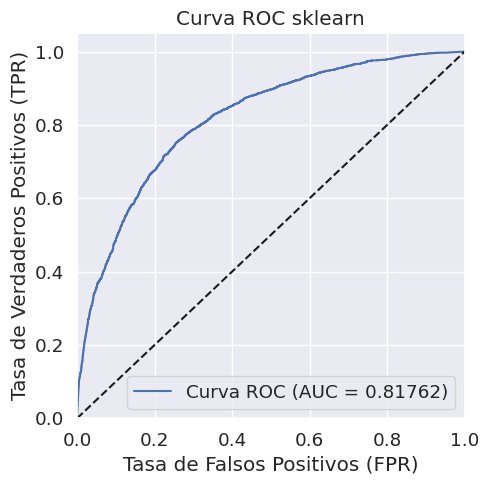

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_np, sklearn_knn_proba)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC sklearn')
plt.legend(loc="lower right")
plt.show()

## Árboles de Decisión

### Entrenamiento

In [ ]:
tree = Node(max_depth=5)
tree.fit(X_train_np, y_train_np)

### Testing

In [ ]:
y_pred_tree = []
for X in X_test_np:
    y_pred_individual = tree.predict(X)
    y_pred_tree.append(y_pred_individual)

y_pred_tree = np.array(y_pred_tree)
y_prob_tree = tree.predict_prob(X_test_np)

y_pred_tree_train = []
for X in X_train_np:
    y_pred_individual = tree.predict(X)
    y_pred_tree_train.append(y_pred_individual)

y_pred_tree_train = np.array(y_pred_tree_train)

### Métricas y Análisis Inicial

Las métricas obtenidas tienen algunos valores buenos y otros regulares, sin embargo no se presenta overfitting ni underfitting.

In [ ]:
our_tree_accuracy_train = accuracy_score(y_train_np, y_pred_tree_train)
our_tree_precision_train = precision_score(y_train_np, y_pred_tree_train)
our_tree_recall_train = recall_score(y_train_np, y_pred_tree_train)
our_tree_f1_train = f1_score(y_train_np, y_pred_tree_train)

our_tree_accuracy = accuracy_score(y_test_np, y_pred_tree)
our_tree_precision = precision_score(y_test_np, y_pred_tree)
our_tree_recall = recall_score(y_test_np, y_pred_tree)
our_tree_f1 = f1_score(y_test_np, y_pred_tree)

print('Our train accuracy:  {0:0.8f}'. format(our_tree_accuracy_train))
print('Our train precision: {0:0.8f}'. format(our_tree_precision_train))
print('Our train recall:    {0:0.8f}'. format(our_tree_recall_train))
print('Our train F1:        {0:0.8f}'. format(our_tree_f1_train))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_tree_accuracy))
print('Our test precision: {0:0.8f}'. format(our_tree_precision))
print('Our test recall:    {0:0.8f}'. format(our_tree_recall))
print('Our test F1:        {0:0.8f}'. format(our_tree_f1))

Our train accuracy:  0.72889213
Our train precision: 0.72271293
Our train recall:    0.66233015
Our train F1:        0.69120531


Our test accuracy:  0.72009789
Our test precision: 0.71645663
Our test recall:    0.64476318
Our test F1:        0.67872191


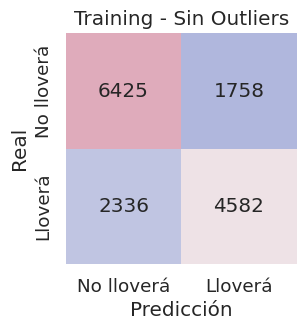

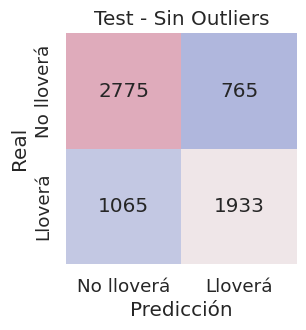

In [ ]:
# confusion matrix
cm_train = confusion_matrix(y_train_np, y_pred_tree_train)
cm_test = confusion_matrix(y_test_np, y_pred_tree)

class_names = ["No lloverá", "Lloverá"]

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_train, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Training - Sin Outliers')
plt.show()

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_test, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Test - Sin Outliers')
plt.show()

La curva ROC es relativamente buena y el valor de AUC es aceptable, se puede decir que el modelo en general discierne bien entre ambas clases.

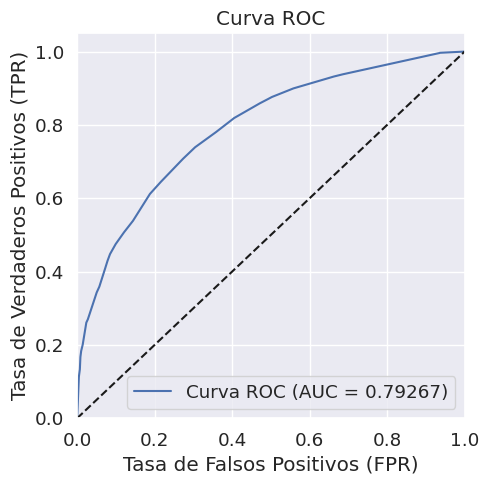

In [ ]:
fpr, tpr, _ = roc_curve(y_test_np, y_prob_tree[:, 1])
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

### Ajuste de Hiperparámetro (profundidad)

In [ ]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 5, 15)

    tree = Node(max_depth=max_depth)
    tree.fit(X_train_np, y_train_np)

    y_pred_tree = []
    for X in X_test_np:
        y_pred_individual = tree.predict(X)
        y_pred_tree.append(y_pred_individual)

    y_pred_tree = np.array(y_pred_tree)

    # métrica a optimizar
    F1 = f1_score(y_test_np, y_pred_tree)

    return F1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
best_recall_score = study.best_value

[I 2023-10-03 07:44:51,088] A new study created in memory with name: no-name-c01e29dd-28a7-4c91-811a-c12b6ef472a4
[I 2023-10-03 07:44:57,927] Trial 0 finished with value: 0.6787219101123596 and parameters: {'max_depth': 5}. Best is trial 0 with value: 0.6787219101123596.
[I 2023-10-03 07:45:05,958] Trial 1 finished with value: 0.6787219101123596 and parameters: {'max_depth': 5}. Best is trial 0 with value: 0.6787219101123596.
[I 2023-10-03 07:45:33,228] Trial 2 finished with value: 0.6775783174938402 and parameters: {'max_depth': 10}. Best is trial 0 with value: 0.6787219101123596.
[I 2023-10-03 07:46:04,665] Trial 3 finished with value: 0.671218487394958 and parameters: {'max_depth': 11}. Best is trial 0 with value: 0.6787219101123596.
[I 2023-10-03 07:46:50,873] Trial 4 finished with value: 0.6619982920580699 and parameters: {'max_depth': 14}. Best is trial 0 with value: 0.6787219101123596.
[I 2023-10-03 07:47:27,632] Trial 5 finished with value: 0.6683778234086243 and parameters: {'

### Resultados finales

In [ ]:
tree = Node(max_depth=best_params['max_depth'])
tree.fit(X_train_np, y_train_np)

y_pred_tree = []
for X in X_test_np:
    y_pred_individual = tree.predict(X)
    y_pred_tree.append(y_pred_individual)

y_pred_tree = np.array(y_pred_tree)
y_prob_tree = tree.predict_prob(X_test_np)

y_pred_tree_train = []
for X in X_train_np:
    y_pred_individual = tree.predict(X)
    y_pred_tree_train.append(y_pred_individual)

y_pred_tree_train = np.array(y_pred_tree_train)

Se presenta overfitting en el modelo, aunque esto es normal y esperable debido a que los Árboles de Decisión se ajustan demasiado a los datos de entrenamiento. Aún así, con el ajuste del hiperparámetro de profunidad, se consiguió levantar un poco la métrica del F1.

In [ ]:
our_tree_accuracy_train = accuracy_score(y_train_np, y_pred_tree_train)
our_tree_precision_train = precision_score(y_train_np, y_pred_tree_train)
our_tree_recall_train = recall_score(y_train_np, y_pred_tree_train)
our_tree_f1_train = f1_score(y_train_np, y_pred_tree_train)

our_tree_accuracy = accuracy_score(y_test_np, y_pred_tree)
our_tree_precision = precision_score(y_test_np, y_pred_tree)
our_tree_recall = recall_score(y_test_np, y_pred_tree)
our_tree_f1 = f1_score(y_test_np, y_pred_tree)

print('Our train accuracy:  {0:0.8f}'. format(our_tree_accuracy_train))
print('Our train precision: {0:0.8f}'. format(our_tree_precision_train))
print('Our train recall:    {0:0.8f}'. format(our_tree_recall_train))
print('Our train F1:        {0:0.8f}'. format(our_tree_f1_train))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_tree_accuracy))
print('Our test precision: {0:0.8f}'. format(our_tree_precision))
print('Our test recall:    {0:0.8f}'. format(our_tree_recall))
print('Our test F1:        {0:0.8f}'. format(our_tree_f1))

Our train accuracy:  0.74001722
Our train precision: 0.74743632
Our train recall:    0.65322347
Our train F1:        0.69716137


Our test accuracy:  0.72973386
Our test precision: 0.73996101
Our test recall:    0.63308873
Our test F1:        0.68236563


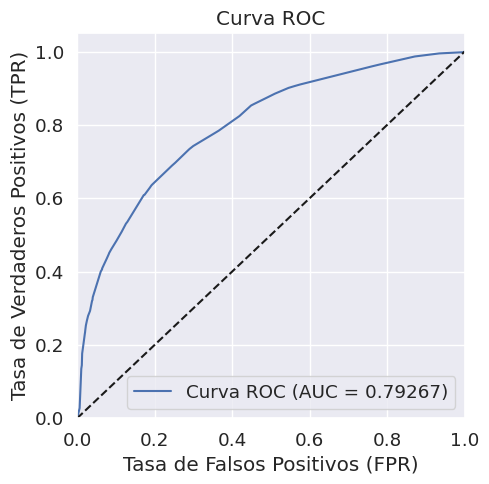

In [ ]:
fpr, tpr, _ = roc_curve(y_test_np, y_prob_tree[:, 1])
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

### Comparación con sklearn

In [ ]:
sklearn_tree = DecisionTreeClassifier(random_state=42)
sklearn_tree.fit(X_train_np, y_train_np)
skleran_tree_pred = sklearn_tree.predict(X_test_np)
sklearn_tree_proba = sklearn_tree.predict_proba(X_test_np)[:, 1]

sklearn_tree_accuracy = accuracy_score(y_test_np, skleran_tree_pred)
sklearn_tree_precision = precision_score(y_test_np, skleran_tree_pred)
sklearn_tree_recall = recall_score(y_test_np, skleran_tree_pred)
sklearn_tree_f1 = f1_score(y_test_np, skleran_tree_pred)

print('sklearn accuracy:  {0:0.8f}'. format(sklearn_tree_accuracy))
print('sklearn precision: {0:0.8f}'. format(sklearn_tree_precision))
print('sklearn recall:    {0:0.8f}'. format(sklearn_tree_recall))
print('sklearn F1:        {0:0.8f}'. format(sklearn_tree_f1))

sklearn accuracy:  0.67788314
sklearn precision: 0.64613368
sklearn recall:    0.65777185
sklearn F1:        0.65190083


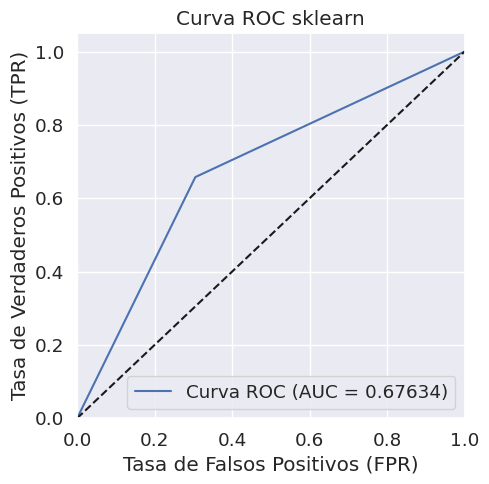

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_np, sklearn_tree_proba)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC sklearn')
plt.legend(loc="lower right")
plt.show()

# Notas del curso de Introducción a la Programación

## Feature Enginering

### Transformación y unión de los datasets

In [749]:
data1 = pd.read_csv("https://raw.githubusercontent.com/danib08/Datasets-Patrones/main/CE1101-1.csv")
data2 = pd.read_csv("https://raw.githubusercontent.com/danib08/Datasets-Patrones/main/CE1101-2.csv", sep=";")
data3 = pd.read_csv("https://raw.githubusercontent.com/danib08/Datasets-Patrones/main/CE1101-3.csv")
data4 = pd.read_csv("https://raw.githubusercontent.com/danib08/Datasets-Patrones/main/CE1101-4.csv")
data5 = pd.read_csv("https://raw.githubusercontent.com/danib08/Datasets-Patrones/main/CE1101-5.csv", sep=";")

In [750]:
# Eliminando columnas innecesarias data1
data1.drop(["Examen 1 Código 0.0%", "Examen 2 Código 0.0%", "Examen 3 Código 0.0%", "Juramento evaluaciones 0.0%", "Total: Juramento 0.0%", "Examen 3 25.0%",
            "Total: Exámenes 75.0%", "Total: Tareas y quices 25.0%", "Matrices 0.0%", "Total: Extra 0.0%", "Tarea1", "Tarea2",
            "Tarea3", "Tarea4", "Tarea5", "Tarea6", "Tarea7", "Tarea8", "Quiz2", "Quiz3", "Quiz4"], axis=1, inplace=True)

# Cambiando nombres de las features
data1.rename(columns={"Examen 1 25.0%": "Examen1"}, inplace=True)
data1.rename(columns={"Examen 2 25.0%": "Examen2"}, inplace=True)
data1.rename(columns={"Total: ": "Nota"}, inplace=True)
data1.head()

,Examen1,Examen2,Quiz1,Nota,Final
0,57.4,75.6,93.3,70.5,70
1,100.0,96.3,86.7,95.8,95
2,19.6,46.7,26.7,44.8,45
3,34.5,34.2,36.7,28.4,30
4,89.5,87.7,93.3,91.4,90


In [751]:
# Eliminando columnas innecesarias data2
data2.drop(["E3 25.00%", "Total: Exámenes 75%", "Total: Quices y Tareas 25%", "Extra 1%", "Q2 3.00%", "Q3 3.00%", "Q4 3.00%",
            "Q5 4.00%", "Q6 2.50%", "Practica 2.00%", "Presentacion 2.5%", "Bibliotecas 2.00%"], axis=1, inplace=True)

# Cambiando nombres de los features
data2.rename(columns={"E1 25.00%": "Examen1"}, inplace=True)
data2.rename(columns={"E2 25.00%": "Examen2"}, inplace=True)
data2.rename(columns={"Q1 3.00%": "Quiz1"}, inplace=True)
data2.rename(columns={"Total: ": "Nota"}, inplace=True)
data2.head()

,Examen1,Examen2,Quiz1,Nota,Final
0,55.0,,73.0,21.94,20.0
1,70.0,70.0,63.0,71.87,70.0
2,15.0,,43.0,10.52,10.0
3,,,0.0,0.00,0.0
4,95.0,,100.0,36.75,35.0


In [752]:
# Eliminando columnas innecesarias data 3
data3.drop(["Demo tec digital 0.00%", "Total: Prueba 0%", "Total: Tarea extra 0%", "Examen 3 25.00%", "Tarea 1", "Tarea 2", "Tarea 3", "Tarea 4", "Tarea 5",
            "Tarea extra 0.00%", "Quiz 2", "Total: Tareas y quices 25%", "Ceremonia acreditación", "Total: Exámenes 75%", "Expo Ordenamiento"], axis=1, inplace=True)
# Cambiando nombres de los features
data3.rename(columns={"Examen 1 25.00%": "Examen1"}, inplace=True)
data3.rename(columns={"Examen 2 25.00%": "Examen2"}, inplace=True)
data3.rename(columns={"Quiz 1": "Quiz1"}, inplace=True)
data3.rename(columns={"Total: ": "Nota"}, inplace=True)
data3.head()

,Examen1,Examen2,Quiz1,Nota,Final
0,39.7,27.4,75,23.17,25
1,32.6,36.6,27.8,37.56,40
2,49.1,0.0,72.2,22.36,20
3,72.4,67.6,90,75.46,75
4,39.9,66.8,50,58.77,60


In [753]:
# Eliminando columnas innecesarias data4
data4.drop(["Prueba", "Total: Prueba TD 0%", "Charla 12 feb 0.00%", "Examen 3 25%", "Total: Exámenes 75%", "Tarea 1", "Tarea 2", "Tarea 3", "Tarea 4",
            "Tarea 5", "Tarea 6", "Tarea 7", "Tarea 8", "Quiz 2", "Quiz 3", "Quiz 4", "Exposición", "Total: Evaluaciones Extra 0%",
            "Total: Tareas y Quices 25%", "Tarea Atributos"], axis=1, inplace=True)

# Cambiando nombres de los features
data4.rename(columns={"Examen 1 25.00%": "Examen1"}, inplace=True)
data4.rename(columns={"Examen 2 25%": "Examen2"}, inplace=True)
data4.rename(columns={"Quiz 1": "Quiz1"}, inplace=True)
data4.rename(columns={"Total: ": "Nota"}, inplace=True)
data4.head()

,Examen1,Examen2,Quiz1,Nota,Final
0,69.3,54,100.0,72.52,75
1,66.9,53.7,86.1,60.78,60
2,92.8,96.5,100.0,95.52,95
3,84,78.5,100.0,86.63,85
4,75.9,84.8,100.0,86.54,85


In [754]:
# Eliminando columnas innecesarias data 5
data5.drop(["Curva 0.00%", "Examen 3 25.00%", "Total: Exámenes 75%", "T1Biblio 4%", "Q2 3.00%", "Q3 4%", "Q4 3.00%", "Q5 3.00%", "Ordenamiento 5.00%",
            "Total: Quices y Tareas 25%"], axis=1, inplace=True)

# Cambiando nombres de los features
data5.rename(columns={"Examen 1 25%": "Examen1"}, inplace=True)
data5.rename(columns={"Examen 2 25.00%": "Examen2"}, inplace=True)
data5.rename(columns={"Q1 3%": "Quiz1"}, inplace=True)
data5.rename(columns={"Total: ": "Nota"}, inplace=True)
data5.head()

,Examen1,Examen2,Quiz1,Nota,Final
0,65.0,100.0,70.0,79.51,80.0
1,15.0,65.0,0.0,39.93,40.0
2,78.0,85.0,61.5,47.75,50.0
3,71.0,80.0,55.0,68.39,70.0
4,18.0,,5.0,8.40,10.0


In [755]:
# Unión de los datasets
data_ce1101 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

### Información descriptiva del dataset

Se observa que el dataset se conforma únicamente de valores númericos, y que tiene presentes valores nulos para las tres features.

In [756]:
# Agrega la columna "Aprobado" basada en la columna "Final"
data_ce1101['Aprobado'] = (data_ce1101['Final'] >= 70).astype(int)
data_ce1101.drop(["Final"], axis=1, inplace=True)

# Limpiar las columnas eliminando espacios en blanco y convirtiéndolos en NaN
data_ce1101['Examen1'] = pd.to_numeric(data_ce1101['Examen1'], errors='coerce')
data_ce1101['Examen2'] = pd.to_numeric(data_ce1101['Examen2'], errors='coerce')
data_ce1101['Quiz1'] = pd.to_numeric(data_ce1101['Quiz1'], errors='coerce')

data_ce1101.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Examen1   121 non-null    float64
 1   Examen2   112 non-null    float64
 2   Quiz1     123 non-null    float64
 3   Nota      124 non-null    float64
 4   Aprobado  124 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 5.0 KB


### Sesgo

El dataset no se encuentra sesgado, por lo que no es necesario hacer cambios en su contenido al respecto.

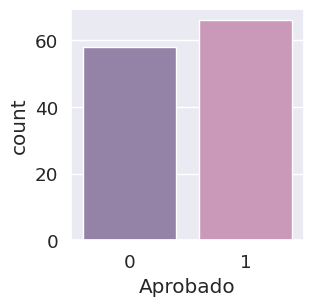

In [757]:
colors= ["#957DAD","#D291BC"]
plt.figure(figsize=(3, 3))
sns.countplot(x=data_ce1101["Aprobado"], palette=colors)
plt.show()

### Matriz de correlación

In [758]:
features = data_ce1101.drop(["Aprobado", "Nota"], axis=1)

Se observa que no se tienen valores altos de correlación, por lo que no se deben eliminar features.

<Axes: >

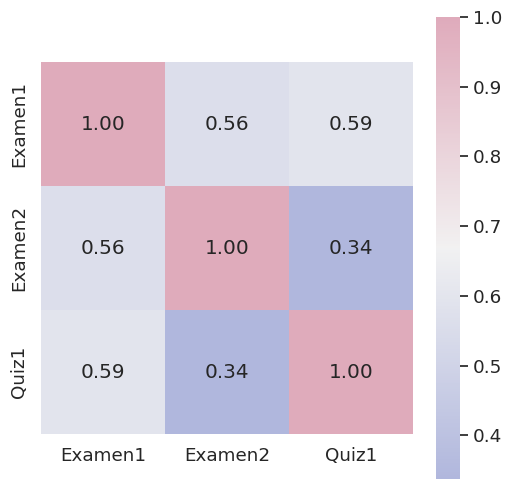

In [759]:
corrmat = features.corr(numeric_only=True)
cmap = sns.diverging_palette(260, -10, s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(6,6))
sns.heatmap(corrmat, cmap=cmap, annot=True, square=True, fmt='.2f')

## Dataset Clasificación

### División en sets de Training / Test

In [673]:
data_ce1101['Aprobado'] = imputer_mode.fit_transform(data_ce1101[['Aprobado']])
target = data_ce1101['Aprobado']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=40, stratify=target)

### Valores nulos

In [674]:
# variables numéricas
nums = (X_train.dtypes == "float64") | (X_train.dtypes == "int64")
numerical = list(nums[nums].index)

# reemplazar nulos por mediana de columna respectiva
X_train[numerical] = imputer_median.fit_transform(X_train[numerical])
X_test[numerical] = imputer_median.transform(X_test[numerical])

# visualizar total de valores nulos
null_counts = X_train[numerical].apply(lambda x: x.isnull().sum()) + X_test[numerical].apply(lambda x: x.isnull().sum())
print(null_counts)

Examen1    0
Examen2    0
Quiz1      0
dtype: int64


### Normalización

In [675]:
# reset indices so StandardScaler doesn't mismatch them
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

s_scaler = StandardScaler()

col_names = list(X_train.columns)

X_train = s_scaler.fit_transform(X_train)
X_test = s_scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=col_names)
X_test = pd.DataFrame(X_test, columns=col_names)

indices_match = X_train.index.equals(y_train.index) and X_test.index.equals(y_test.index)

if indices_match:
    print("Indices match.")
else:
    print("Indices do not match.")

Indices match.


### Análisis de Outliers / Caja de Bigotes

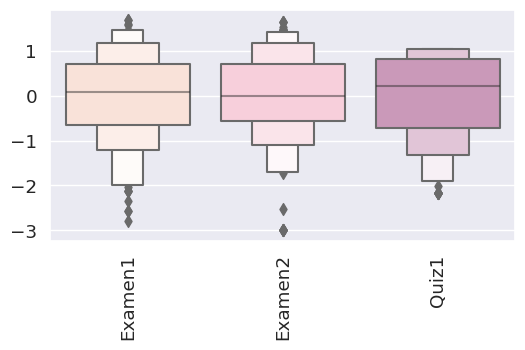

In [676]:
combined_data = pd.concat([X_train, X_test], axis=0)

colors = ["#FFDFD3", "#FEC8D8", "#D291BC", "#957DAD", "#E0BBE4"]
plt.figure(figsize=(6,3))
sns.boxenplot(data = combined_data, palette = colors)
plt.xticks(rotation=90)
plt.show()

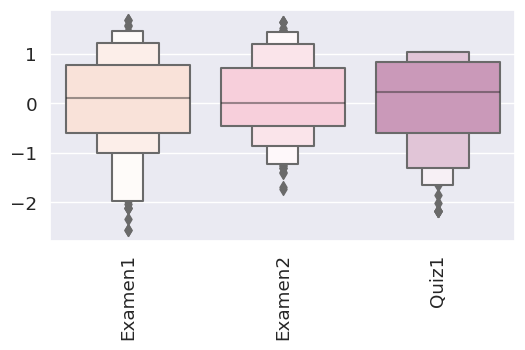

In [677]:
# funcion para eliminar outliers
def remove_outliers(dataframe, X_train, X_test, y_train, y_test, column, multiplier=1.5):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_fence = Q1 - (IQR * multiplier)
    upper_fence = Q3 + (IQR * multiplier)

    mask_train = (X_train[column] >= lower_fence) & (X_train[column] <= upper_fence)
    mask_test = (X_test[column] >= lower_fence) & (X_test[column] <= upper_fence)

    cleaned_X_train = X_train[mask_train]
    cleaned_X_test = X_test[mask_test]

    cleaned_y_train = y_train[mask_train]
    cleaned_y_test = y_test[mask_test]

    return cleaned_X_train, cleaned_X_test, cleaned_y_train, cleaned_y_test

# features en las cuales se eliminaran outliers
features_to_remove_outliers = ['Examen1', 'Examen2', 'Quiz1']

X_train_clean = X_train.copy()
X_test_clean = X_test.copy()
y_train_clean = y_train.copy()
y_test_clean = y_test.copy()

for feature in features_to_remove_outliers:
     X_train_clean, X_test_clean, y_train_clean, y_test_clean = remove_outliers(combined_data, X_train_clean, X_test_clean, y_train_clean, y_test_clean, feature)

combined_data_clean = pd.concat([X_train_clean, X_test_clean], axis=0)
plt.figure(figsize=(6,3))
sns.boxenplot(data = combined_data_clean, palette = colors)
plt.xticks(rotation=90)
plt.show()

## Dataset Predicción

### División en sets de Training / Test

In [760]:
data_ce1101['Nota'] = imputer_mode.fit_transform(data_ce1101[['Nota']])
target_linear = data_ce1101['Nota']

X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(features, target_linear, test_size=0.2, random_state=46, stratify=target)

### Valores nulos

In [761]:
# variables numéricas
nums = (X_train_linear.dtypes == "float64") | (X_train_linear.dtypes == "int64")
numerical = list(nums[nums].index)

# reemplazar nulos por mediana de columna respectiva
X_train_linear[numerical] = imputer_median.fit_transform(X_train_linear[numerical])
X_test_linear[numerical] = imputer_median.transform(X_test_linear[numerical])

# visualizar total de valores nulos
null_counts = X_train_linear[numerical].apply(lambda x: x.isnull().sum()) + X_test_linear[numerical].apply(lambda x: x.isnull().sum())
print(null_counts)

Examen1    0
Examen2    0
Quiz1      0
dtype: int64


### Normalización

In [762]:
# reset indices so StandardScaler doesn't mismatch them
X_train_linear.reset_index(drop=True, inplace=True)
X_test_linear.reset_index(drop=True, inplace=True)
y_train_linear.reset_index(drop=True, inplace=True)
y_test_linear.reset_index(drop=True, inplace=True)

s_scaler = StandardScaler()

col_names = list(X_train_linear.columns)

X_train_linear = s_scaler.fit_transform(X_train_linear)
X_test_linear = s_scaler.transform(X_test_linear)

X_train_linear = pd.DataFrame(X_train_linear, columns=col_names)
X_test_linear = pd.DataFrame(X_test_linear, columns=col_names)

indices_match = X_train_linear.index.equals(y_train.index) and X_test_linear.index.equals(y_test.index)

if indices_match:
    print("Indices match.")
else:
    print("Indices do not match.")

Indices match.


### Análisis de Outliers / Caja de Bigotes

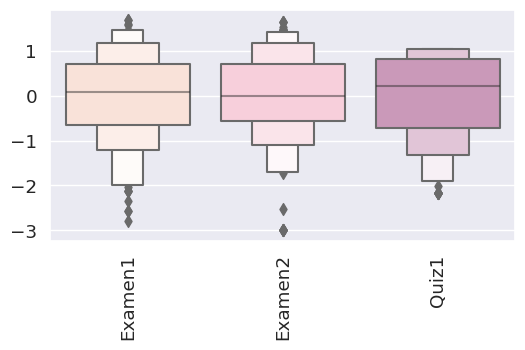

In [763]:
combined_data_linear = pd.concat([X_train_linear, X_test_linear], axis=0)

colors = ["#FFDFD3", "#FEC8D8", "#D291BC", "#957DAD", "#E0BBE4"]
plt.figure(figsize=(6,3))
sns.boxenplot(data = combined_data, palette = colors)
plt.xticks(rotation=90)
plt.show()

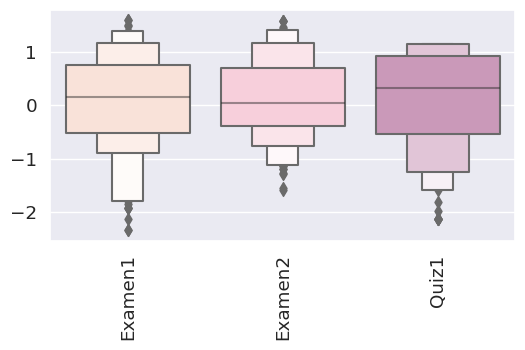

In [764]:
# funcion para eliminar outliers
def remove_outliers(dataframe, X_train, X_test, y_train, y_test, column, multiplier=1.5):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_fence = Q1 - (IQR * multiplier)
    upper_fence = Q3 + (IQR * multiplier)

    mask_train = (X_train[column] >= lower_fence) & (X_train[column] <= upper_fence)
    mask_test = (X_test[column] >= lower_fence) & (X_test[column] <= upper_fence)

    cleaned_X_train = X_train[mask_train]
    cleaned_X_test = X_test[mask_test]

    cleaned_y_train = y_train[mask_train]
    cleaned_y_test = y_test[mask_test]

    return cleaned_X_train, cleaned_X_test, cleaned_y_train, cleaned_y_test

# features en las cuales se eliminaran outliers
features_to_remove_outliers = ['Examen1', 'Examen2', 'Quiz1']

X_train_clean_linear = X_train_linear.copy()
X_test_clean_linear = X_test_linear.copy()
y_train_clean_linear = y_train_linear.copy()
y_test_clean_linear = y_test_linear.copy()

for feature in features_to_remove_outliers:
     X_train_clean_linear, X_test_clean_linear, y_train_clean_linear, y_test_clean_linear = remove_outliers(combined_data_linear, X_train_clean_linear, X_test_clean_linear, y_train_clean_linear, y_test_clean_linear, feature)

combined_data_clean_linear = pd.concat([X_train_clean_linear, X_test_clean_linear], axis=0)
plt.figure(figsize=(6,3))
sns.boxenplot(data = combined_data_clean_linear, palette = colors)
plt.xticks(rotation=90)
plt.show()

## Regresión Logística

### Entrenamiento

Se entrenarán dos modelos, uno con el dataset sin outliers y otro con outliers. Esto para mostrar las diferencias en métricas en ambos casos.

In [ ]:
# con outliers
our_logreg = OurLogisticRegression(0.15, 20000)
our_logreg.fit(X_train, y_train)

# sin outliers
our_logreg_clean = OurLogisticRegression(0.15, 20000)
our_logreg_clean.fit(X_train_clean, y_train_clean)

### Testing

In [ ]:
# con outliers
y_pred_logreg = our_logreg.predict(X_test, threshold=0.5)
y_pred_train_logreg = our_logreg.predict(X_train, threshold=0.5)
y_prob_logreg = our_logreg.predict_prob(X_test)

# sin outliers
y_pred_logreg_clean = our_logreg_clean.predict(X_test_clean, threshold=0.5)
y_pred_train_logreg_clean = our_logreg_clean.predict(X_train_clean, threshold=0.5)
y_prob_logreg_clean = our_logreg_clean.predict_prob(X_test_clean)

### Métricas y Análisis Inicial

Estas métricas iniciales muestran un desempeño excelente para este modelo, y no se presenta overfitting ni underfitting. Las métricas se mantienen similares tanto con outliers como sin outliers, por lo que se trabajará sin outliers.

In [ ]:
# accuracy, precision, recall, f1

# con outliers
our_logreg_train_accuracy = accuracy_score(y_train, y_pred_train_logreg)
our_logreg_train_precision = precision_score(y_train, y_pred_train_logreg)
our_logreg_train_recall = recall_score(y_train, y_pred_train_logreg)
our_logreg_train_f1 = f1_score(y_train, y_pred_train_logreg)

our_logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
our_logreg_precision = precision_score(y_test, y_pred_logreg)
our_logreg_recall = recall_score(y_test, y_pred_logreg)
our_logreg_f1 = f1_score(y_test, y_pred_logreg)

# sin outliers
our_logreg_train_accuracy_clean = accuracy_score(y_train_clean, y_pred_train_logreg_clean)
our_logreg_train_precision_clean = precision_score(y_train_clean, y_pred_train_logreg_clean)
our_logreg_train_recall_clean = recall_score(y_train_clean, y_pred_train_logreg_clean)
our_logreg_train_f1_clean = f1_score(y_train_clean, y_pred_train_logreg_clean)

our_logreg_accuracy_clean = accuracy_score(y_test_clean, y_pred_logreg_clean)
our_logreg_precision_clean = precision_score(y_test_clean, y_pred_logreg_clean)
our_logreg_recall_clean = recall_score(y_test_clean, y_pred_logreg_clean)
our_logreg_f1_clean = f1_score(y_test_clean, y_pred_logreg_clean)

print("----- DATASET CON OUTLIERS -----")
print('Our training accuracy:  {0:0.8f}'. format(our_logreg_train_accuracy))
print('Our training precision: {0:0.8f}'. format(our_logreg_train_precision))
print('Our training recall:    {0:0.8f}'. format(our_logreg_train_recall))
print('Our training F1:        {0:0.8f}'. format(our_logreg_train_f1))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_logreg_accuracy))
print('Our test precision: {0:0.8f}'. format(our_logreg_precision))
print('Our test recall:    {0:0.8f}'. format(our_logreg_recall))
print('Our test F1:        {0:0.8f}'. format(our_logreg_f1))
print("\n")

print("----- DATASET SIN OUTLIERS -----")
print('Our training accuracy:  {0:0.8f}'. format(our_logreg_train_accuracy_clean))
print('Our training precision: {0:0.8f}'. format(our_logreg_train_precision_clean))
print('Our training recall:    {0:0.8f}'. format(our_logreg_train_recall_clean))
print('Our training F1:        {0:0.8f}'. format(our_logreg_train_f1_clean))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_logreg_accuracy_clean))
print('Our test precision: {0:0.8f}'. format(our_logreg_precision_clean))
print('Our test recall:    {0:0.8f}'. format(our_logreg_recall_clean))
print('Our test F1:        {0:0.8f}'. format(our_logreg_f1_clean))

----- DATASET CON OUTLIERS -----
Our training accuracy:  0.83838384
Our training precision: 0.83636364
Our training recall:    0.86792453
Our training F1:        0.85185185


Our test accuracy:  0.92000000
Our test precision: 1.00000000
Our test recall:    0.84615385
Our test F1:        0.91666667


----- DATASET SIN OUTLIERS -----
Our training accuracy:  0.83157895
Our training precision: 0.83636364
Our training recall:    0.86792453
Our training F1:        0.85185185


Our test accuracy:  0.90909091
Our test precision: 1.00000000
Our test recall:    0.84615385
Our test F1:        0.91666667


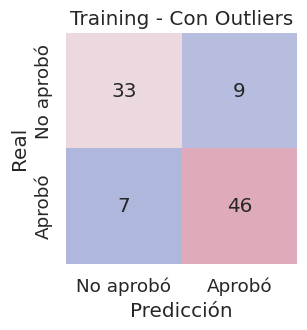

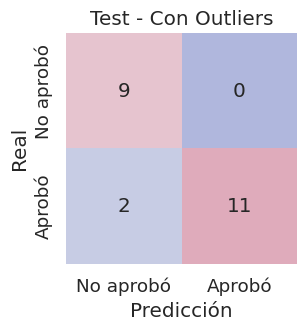

In [ ]:
# confusion matrix
cm_train = confusion_matrix(y_train_clean, y_pred_train_logreg_clean)
cm_test = confusion_matrix(y_test_clean, y_pred_logreg_clean)

class_names = ["No aprobó", "Aprobó"]

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_train, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Training - Con Outliers')
plt.show()

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_test, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Test - Con Outliers')
plt.show()

La curva ROC muestra una forma sumamente peculiar, y es debido a esto que el área bajo la curva da casi 1, lo que indica que el modelo es excelente.

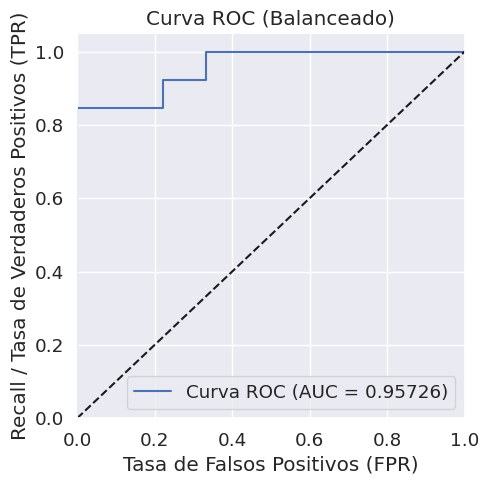

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_clean, y_prob_logreg_clean)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC (Balanceado)')
plt.legend(loc="lower right")
plt.show()

### Ajuste de Hiperparámetros

In [ ]:
def objective(trial):
    lr = trial.suggest_float('lr', 0.01, 0.5, log=True)
    num_iter = trial.suggest_int('num_iter', 20000, 200000)

    model = OurLogisticRegression(lr=lr, num_iter=num_iter)

    model.fit(X_train_clean, y_train_clean)

    y_pred = model.predict(X_test, threshold=0.5)

    # métrica a optimizar
    F1 = f1_score(y_test, y_pred)

    return F1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
best_recall_score = study.best_value

[I 2023-10-03 07:02:04,316] A new study created in memory with name: no-name-d07937a3-595d-4c57-a84d-921baf6f76a3
[I 2023-10-03 07:02:22,069] Trial 0 finished with value: 0.9166666666666666 and parameters: {'lr': 0.1876357387757969, 'num_iter': 47527}. Best is trial 0 with value: 0.9166666666666666.
[I 2023-10-03 07:03:14,426] Trial 1 finished with value: 0.9166666666666666 and parameters: {'lr': 0.058184836912247496, 'num_iter': 167783}. Best is trial 0 with value: 0.9166666666666666.
[I 2023-10-03 07:03:42,349] Trial 2 finished with value: 0.9166666666666666 and parameters: {'lr': 0.08620230456093421, 'num_iter': 97285}. Best is trial 0 with value: 0.9166666666666666.
[I 2023-10-03 07:04:17,853] Trial 3 finished with value: 0.9166666666666666 and parameters: {'lr': 0.032534402165248104, 'num_iter': 147069}. Best is trial 0 with value: 0.9166666666666666.
[I 2023-10-03 07:04:44,668] Trial 4 finished with value: 0.9166666666666666 and parameters: {'lr': 0.049205795815439546, 'num_iter'

### Resultados finales - Ajuste de Umbral

In [ ]:
our_logreg = OurLogisticRegression(best_params['lr'], best_params['num_iter'])
our_logreg.fit(X_train_clean, y_train_clean)
y_prob_logreg = our_logreg.predict_prob(X_test_clean)

# umbrales a probar
thresholds = np.linspace(0, 1, 101)
best_threshold = 0
best_f1 = 0

for threshold in thresholds:
    y_pred = (y_prob_logreg > threshold).astype(int)
    f1 = f1_score(y_test_clean, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

y_pred_best = (y_prob_logreg > best_threshold).astype(int)

# accuracy, precision, recall, f1
our_logreg_reg_accuracy = accuracy_score(y_test_clean, y_pred_best)
our_logreg_reg_precision = precision_score(y_test_clean, y_pred_best)
our_logreg_reg_recall = recall_score(y_test_clean, y_pred_best)
our_logreg_reg_f1 = f1_score(y_test_clean, y_pred_best)

print('Our accuracy:  {0:0.8f}'. format(our_logreg_reg_accuracy))
print('Our precision: {0:0.8f}'. format(our_logreg_reg_precision))
print('Our recall:    {0:0.8f}'. format(our_logreg_reg_recall))
print('Our F1:        {0:0.8f}'. format(our_logreg_reg_f1))

Our accuracy:  0.90909091
Our precision: 1.00000000
Our recall:    0.84615385
Our F1:        0.91666667


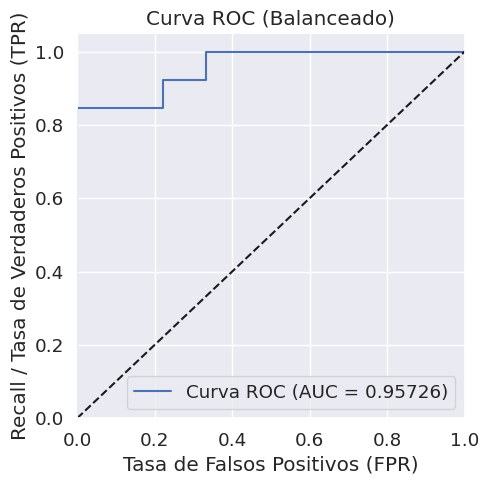

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_clean, y_prob_logreg)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC (Balanceado)')
plt.legend(loc="lower right")
plt.show()

### Comparación con sklearn

In [ ]:
skleran_logreg = LogisticRegression(random_state=42)
skleran_logreg.fit(X_train_clean, y_train_clean)
skleran_logreg_pred = skleran_logreg.predict(X_test_clean)
sklearn_y_proba = skleran_logreg.predict_proba(X_test_clean)[:, 1]

sklearn_logreg_accuracy = accuracy_score(y_test_clean, skleran_logreg_pred)
sklearn_logreg_precision = precision_score(y_test_clean, skleran_logreg_pred)
sklearn_logreg_recall = recall_score(y_test_clean, skleran_logreg_pred)
sklearn_logreg_f1 = f1_score(y_test_clean, skleran_logreg_pred)

print('sklearn accuracy:  {0:0.8f}'. format(sklearn_logreg_accuracy))
print('sklearn precision: {0:0.8f}'. format(sklearn_logreg_precision))
print('sklearn recall:    {0:0.8f}'. format(sklearn_logreg_recall))
print('sklearn F1:        {0:0.8f}'. format(sklearn_logreg_f1))

sklearn accuracy:  0.90909091
sklearn precision: 1.00000000
sklearn recall:    0.84615385
sklearn F1:        0.91666667


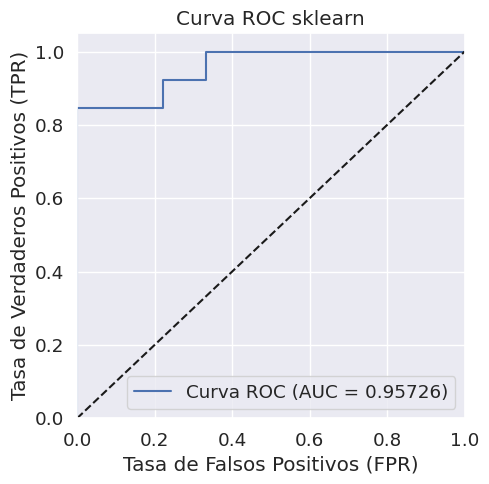

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_clean, sklearn_y_proba)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC sklearn')
plt.legend(loc="lower right")
plt.show()

## K-Nearest Neighbors


### Conversión a NumPy arrays

In [ ]:
X_test_np = X_test_clean.to_numpy()
y_test_np = y_test_clean.to_numpy()

X_train_np = X_train_clean.to_numpy()
y_train_np = y_train_clean.to_numpy()

### Entrenamiento

In [ ]:
our_knn = OurKNearest(X_train_np, y_train_np, n_neighbors=5, weights='distance', n_classes=2, distance='minkowski', p=0.7)

### Testing

In [ ]:
y_pred_knn_train = our_knn.predict(X_train_np, return_prob=False)
y_pred_knn, y_prob_knn = our_knn.predict(X_test_np)

### Métricas y Análisis Inicial

Las métricas brindan valores excelentes, y esto puede explicarse debido al dataset. A pesar de que KNN no es el mejor algoritmo de clasificación, se comporta muy bien en este caso ya que el set de datos es muy fácil de manejar.

In [ ]:
our_knn_accuracy_train = accuracy_score(y_train_np, y_pred_knn_train)
our_knn_precision_train = precision_score(y_train_np, y_pred_knn_train)
our_knn_recall_train = recall_score(y_train_np, y_pred_knn_train)
our_knn_f1_train = f1_score(y_train_np, y_pred_knn_train)

our_knn_accuracy = accuracy_score(y_test_np, y_pred_knn)
our_knn_precision = precision_score(y_test_np, y_pred_knn)
our_knn_recall = recall_score(y_test_np, y_pred_knn)
our_knn_f1 = f1_score(y_test_np, y_pred_knn)

print('Our train accuracy:  {0:0.8f}'. format(our_knn_accuracy_train))
print('Our train precision: {0:0.8f}'. format(our_knn_precision_train))
print('Our train recall:    {0:0.8f}'. format(our_knn_recall_train))
print('Our train F1:        {0:0.8f}'. format(our_knn_f1_train))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_knn_accuracy))
print('Our test precision: {0:0.8f}'. format(our_knn_precision))
print('Our test recall:    {0:0.8f}'. format(our_knn_recall))
print('Our test F1:        {0:0.8f}'. format(our_knn_f1))

Our train accuracy:  0.83157895
Our train precision: 0.83636364
Our train recall:    0.86792453
Our train F1:        0.85185185


Our test accuracy:  0.90909091
Our test precision: 0.92307692
Our test recall:    0.92307692
Our test F1:        0.92307692


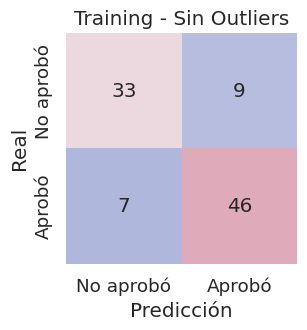

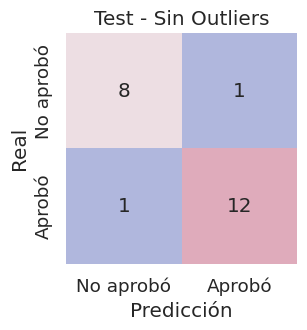

In [ ]:
# confusion matrix
cm_train = confusion_matrix(y_train_np, y_pred_knn_train)
cm_test = confusion_matrix(y_test_np, y_pred_knn)

class_names = ["No aprobó", "Aprobó"]

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_train, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Training - Sin Outliers')
plt.show()

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_test, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Test - Sin Outliers')
plt.show()

Sin embargo, la curva ROC se acerca demasiado a la diagonal, lo que quiere decir que la habilidad del modelo para diferenciar las clases no es tan buena. Además es importante tomar en cuenta que el algoritmo KNN no es probabilístico  como otros (por ejemplo, regresión logística), por lo que una curva ROC que toma en cuenta las probabilidades y umbrales, tal vea no es ideal para KNN.

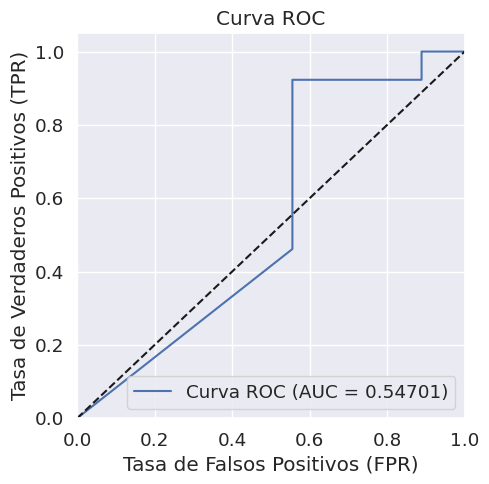

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_np, y_prob_knn[:, 1])
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Ajuste de Hiperparámetro (k)

In [ ]:
def objective(trial):
    k = trial.suggest_int('k', 5, 30)

    model = OurKNearest(X_train_np, y_train_np, n_neighbors=k, weights='distance', n_classes=2, distance='minkowski', p=0.7)
    y_pred = our_knn.predict(X_test_np, return_prob=False)

    # métrica a optimizar
    F1 = f1_score(y_test_np, y_pred)

    return F1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

best_params = study.best_params
best_recall_score = study.best_value

[I 2023-10-03 17:32:33,150] A new study created in memory with name: no-name-f24dc619-4511-48cc-952e-52a21e1b9452
[I 2023-10-03 17:32:33,180] Trial 0 finished with value: 0.9166666666666666 and parameters: {'k': 19}. Best is trial 0 with value: 0.9166666666666666.
[I 2023-10-03 17:32:33,195] Trial 1 finished with value: 0.9166666666666666 and parameters: {'k': 20}. Best is trial 0 with value: 0.9166666666666666.
[I 2023-10-03 17:32:33,211] Trial 2 finished with value: 0.9166666666666666 and parameters: {'k': 7}. Best is trial 0 with value: 0.9166666666666666.
[I 2023-10-03 17:32:33,226] Trial 3 finished with value: 0.9166666666666666 and parameters: {'k': 24}. Best is trial 0 with value: 0.9166666666666666.
[I 2023-10-03 17:32:33,239] Trial 4 finished with value: 0.9166666666666666 and parameters: {'k': 12}. Best is trial 0 with value: 0.9166666666666666.
[I 2023-10-03 17:32:33,255] Trial 5 finished with value: 0.9166666666666666 and parameters: {'k': 9}. Best is trial 0 with value: 0.

### Resultados finales

Con el ajuste del hiperparámetro k, se logró aumentar el AUC, por lo que se concluye el valor tan bajo que se tuvo inicialmente se dio debido a la mala elección del número de vecinos.

In [ ]:
our_knn = OurKNearest(X_train_np, y_train_np, n_neighbors=best_params['k'], weights='distance', n_classes=2, distance='minkowski', p=0.7)

y_pred_knn_train = our_knn.predict(X_train_np, return_prob=False)
y_pred_knn, y_prob_knn = our_knn.predict(X_test_np)

In [ ]:
our_knn_accuracy_train = accuracy_score(y_train_np, y_pred_knn_train)
our_knn_precision_train = precision_score(y_train_np, y_pred_knn_train)
our_knn_recall_train = recall_score(y_train_np, y_pred_knn_train)
our_knn_f1_train = f1_score(y_train_np, y_pred_knn_train)

our_knn_accuracy = accuracy_score(y_test_np, y_pred_knn)
our_knn_precision = precision_score(y_test_np, y_pred_knn)
our_knn_recall = recall_score(y_test_np, y_pred_knn)
our_knn_f1 = f1_score(y_test_np, y_pred_knn)


print('Our train accuracy:  {0:0.8f}'. format(our_knn_accuracy_train))
print('Our train precision: {0:0.8f}'. format(our_knn_precision_train))
print('Our train recall:    {0:0.8f}'. format(our_knn_recall_train))
print('Our train F1:        {0:0.8f}'. format(our_knn_f1_train))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_knn_accuracy))
print('Our test precision: {0:0.8f}'. format(our_knn_precision))
print('Our test recall:    {0:0.8f}'. format(our_knn_recall))
print('Our test F1:        {0:0.8f}'. format(our_knn_f1))

Our train accuracy:  0.80000000
Our train precision: 0.78333333
Our train recall:    0.88679245
Our train F1:        0.83185841


Our test accuracy:  0.95454545
Our test precision: 1.00000000
Our test recall:    0.92307692
Our test F1:        0.96000000


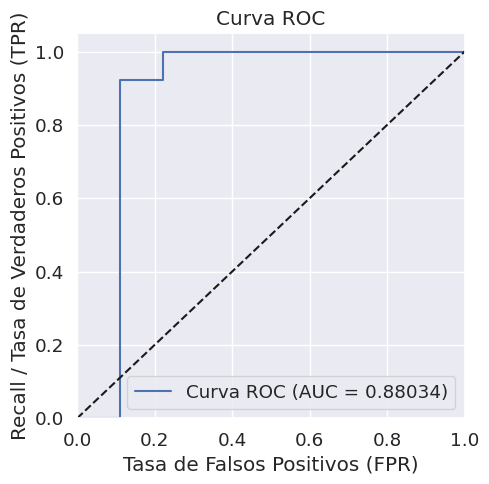

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_np, y_prob_knn[:, 1])
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Comparación con sklearn

In [ ]:
sklearn_knn = KNeighborsClassifier(n_neighbors=best_params['k'], weights='distance')
sklearn_knn.fit(X_train_np, y_train_np)
skleran_knn_pred = sklearn_knn.predict(X_test_np)
sklearn_knn_proba = sklearn_knn.predict_proba(X_test_np)[:, 1]

sklearn_knn_accuracy = accuracy_score(y_test_np, skleran_knn_pred)
sklearn_knn_precision = precision_score(y_test_np, skleran_knn_pred)
sklearn_knn_recall = recall_score(y_test_np, skleran_knn_pred)
sklearn_knn_f1 = f1_score(y_test_np, skleran_knn_pred)

print('sklearn accuracy:  {0:0.8f}'. format(sklearn_knn_accuracy))
print('sklearn precision: {0:0.8f}'. format(sklearn_knn_precision))
print('sklearn recall:    {0:0.8f}'. format(sklearn_knn_recall))
print('sklearn F1:        {0:0.8f}'. format(sklearn_knn_f1))

sklearn accuracy:  0.90909091
sklearn precision: 0.92307692
sklearn recall:    0.92307692
sklearn F1:        0.92307692


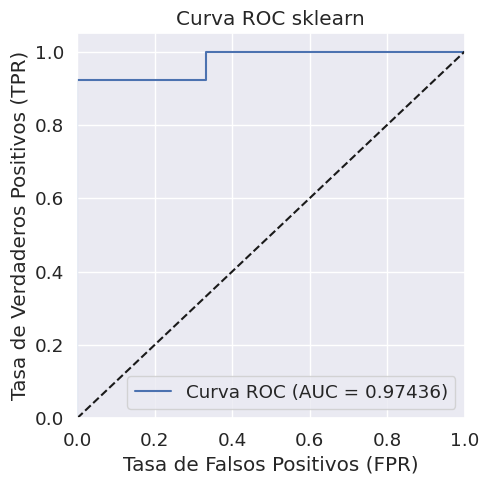

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_np, sklearn_knn_proba)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC sklearn')
plt.legend(loc="lower right")
plt.show()

## Árboles de Decisión

### Entrenamiento

In [ ]:
tree = Node(max_depth=5)
tree.fit(X_train_np, y_train_np)

### Testing

In [ ]:
y_pred_tree = []
for X in X_test_np:
    y_pred_individual = tree.predict(X)
    y_pred_tree.append(y_pred_individual)

y_pred_tree = np.array(y_pred_tree)
y_prob_tree = tree.predict_prob(X_test_np)

y_pred_tree_train = []
for X in X_train_np:
    y_pred_individual = tree.predict(X)
    y_pred_tree_train.append(y_pred_individual)

y_pred_tree_train = np.array(y_pred_tree_train)

### Métricas y Análisis Inicial

Las métricas brindan valores buenos, sin embargo, se presentva overfitting con esta profudidad máxima inicial.

In [ ]:
our_tree_accuracy_train = accuracy_score(y_train_np, y_pred_tree_train)
our_tree_precision_train = precision_score(y_train_np, y_pred_tree_train)
our_tree_recall_train = recall_score(y_train_np, y_pred_tree_train)
our_tree_f1_train = f1_score(y_train_np, y_pred_tree_train)

our_tree_accuracy = accuracy_score(y_test_np, y_pred_tree)
our_tree_precision = precision_score(y_test_np, y_pred_tree)
our_tree_recall = recall_score(y_test_np, y_pred_tree)
our_tree_f1 = f1_score(y_test_np, y_pred_tree)

print('Our train accuracy:  {0:0.8f}'. format(our_tree_accuracy_train))
print('Our train precision: {0:0.8f}'. format(our_tree_precision_train))
print('Our train recall:    {0:0.8f}'. format(our_tree_recall_train))
print('Our train F1:        {0:0.8f}'. format(our_tree_f1_train))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_tree_accuracy))
print('Our test precision: {0:0.8f}'. format(our_tree_precision))
print('Our test recall:    {0:0.8f}'. format(our_tree_recall))
print('Our test F1:        {0:0.8f}'. format(our_tree_f1))

Our train accuracy:  0.96842105
Our train precision: 1.00000000
Our train recall:    0.94339623
Our train F1:        0.97087379


Our test accuracy:  0.72727273
Our test precision: 0.81818182
Our test recall:    0.69230769
Our test F1:        0.75000000


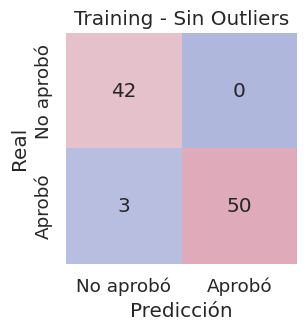

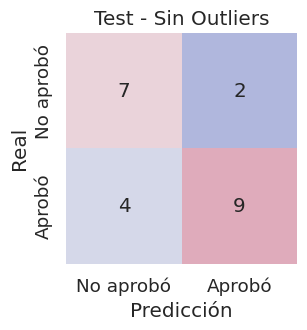

In [ ]:
# confusion matrix
cm_train = confusion_matrix(y_train_np, y_pred_tree_train)
cm_test = confusion_matrix(y_test_np, y_pred_tree)

class_names = ["No aprobó", "Aprobó"]

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_train, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Training - Sin Outliers')
plt.show()

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_test, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Test - Sin Outliers')
plt.show()

El valor de AUC es muy malo, y la curva ROC nos dice que el modelo tiene problemas para separar de buena manera las clases.

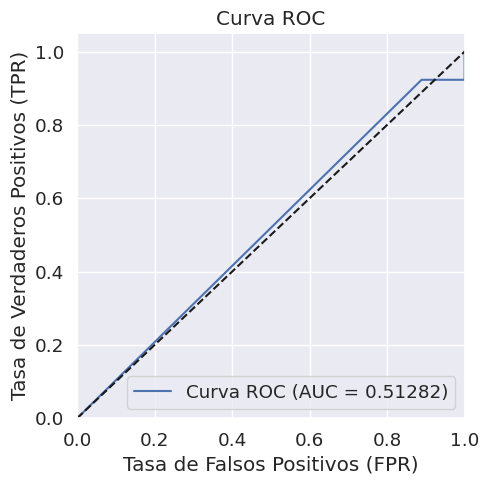

In [ ]:
fpr, tpr, _ = roc_curve(y_test_np, y_prob_tree[:, 1])
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

### Ajuste de Hiperparámetro (profundidad)

Se ajustará el AUC al mejor valor posible, ya que es la métrica con el peor desempeño en el análisis inicial.

In [ ]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 10)

    tree = Node(max_depth=max_depth)
    tree.fit(X_train_np, y_train_np)

    y_prob_tree = tree.predict_prob(X_test_np)

    fpr, tpr, _ = roc_curve(y_test_np, y_prob_tree[:, 1])
    # métrica a optimizar
    roc_auc_curve = auc(fpr, tpr)

    return roc_auc_curve

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

best_params = study.best_params
best_recall_score = study.best_value

[I 2023-10-03 18:30:50,845] A new study created in memory with name: no-name-ac03907f-e454-4474-b9d1-d94db4b8f769
[I 2023-10-03 18:30:50,901] Trial 0 finished with value: 0.7905982905982906 and parameters: {'max_depth': 1}. Best is trial 0 with value: 0.7905982905982906.
[I 2023-10-03 18:30:51,029] Trial 1 finished with value: 0.5 and parameters: {'max_depth': 9}. Best is trial 0 with value: 0.7905982905982906.
[I 2023-10-03 18:30:51,111] Trial 2 finished with value: 0.6068376068376068 and parameters: {'max_depth': 2}. Best is trial 0 with value: 0.7905982905982906.
[I 2023-10-03 18:30:51,238] Trial 3 finished with value: 0.5 and parameters: {'max_depth': 9}. Best is trial 0 with value: 0.7905982905982906.
[I 2023-10-03 18:30:51,388] Trial 4 finished with value: 0.5 and parameters: {'max_depth': 9}. Best is trial 0 with value: 0.7905982905982906.
[I 2023-10-03 18:30:51,478] Trial 5 finished with value: 0.623931623931624 and parameters: {'max_depth': 3}. Best is trial 0 with value: 0.79

### Resultados finales

En este caso, se acepta una penalización en las métricas de accuracy, precision, recall y F1 para así mejorar el AUC.

In [ ]:
tree = Node(max_depth=best_params['max_depth'])
tree.fit(X_train_np, y_train_np)

y_pred_tree = []
for X in X_test_np:
    y_pred_individual = tree.predict(X)
    y_pred_tree.append(y_pred_individual)

y_pred_tree = np.array(y_pred_tree)
y_prob_tree = tree.predict_prob(X_test_np)

y_pred_tree_train = []
for X in X_train_np:
    y_pred_individual = tree.predict(X)
    y_pred_tree_train.append(y_pred_individual)

y_pred_tree_train = np.array(y_pred_tree_train)

In [ ]:
our_tree_accuracy_train = accuracy_score(y_train_np, y_pred_tree_train)
our_tree_precision_train = precision_score(y_train_np, y_pred_tree_train)
our_tree_recall_train = recall_score(y_train_np, y_pred_tree_train)
our_tree_f1_train = f1_score(y_train_np, y_pred_tree_train)

our_tree_accuracy = accuracy_score(y_test_np, y_pred_tree)
our_tree_precision = precision_score(y_test_np, y_pred_tree)
our_tree_recall = recall_score(y_test_np, y_pred_tree)
our_tree_f1 = f1_score(y_test_np, y_pred_tree)

print('Our train accuracy:  {0:0.8f}'. format(our_tree_accuracy_train))
print('Our train precision: {0:0.8f}'. format(our_tree_precision_train))
print('Our train recall:    {0:0.8f}'. format(our_tree_recall_train))
print('Our train F1:        {0:0.8f}'. format(our_tree_f1_train))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_tree_accuracy))
print('Our test precision: {0:0.8f}'. format(our_tree_precision))
print('Our test recall:    {0:0.8f}'. format(our_tree_recall))
print('Our test F1:        {0:0.8f}'. format(our_tree_f1))

Our train accuracy:  0.77894737
Our train precision: 0.94444444
Our train recall:    0.64150943
Our train F1:        0.76404494


Our test accuracy:  0.77272727
Our test precision: 0.90000000
Our test recall:    0.69230769
Our test F1:        0.78260870


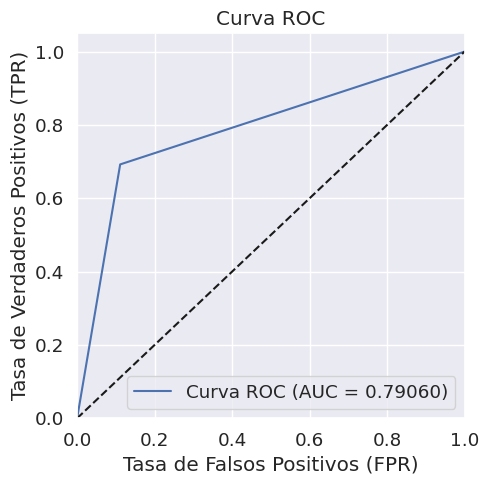

In [ ]:
fpr, tpr, _ = roc_curve(y_test_np, y_prob_tree[:, 1])
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

### Comparación con sklearn

In [ ]:
sklearn_tree = DecisionTreeClassifier(random_state=42)
sklearn_tree.fit(X_train_np, y_train_np)
skleran_tree_pred = sklearn_tree.predict(X_test_np)
sklearn_tree_proba = sklearn_tree.predict_proba(X_test_np)[:, 1]

sklearn_tree_accuracy = accuracy_score(y_test_np, skleran_tree_pred)
sklearn_tree_precision = precision_score(y_test_np, skleran_tree_pred)
sklearn_tree_recall = recall_score(y_test_np, skleran_tree_pred)
sklearn_tree_f1 = f1_score(y_test_np, skleran_tree_pred)

print('sklearn accuracy:  {0:0.8f}'. format(sklearn_tree_accuracy))
print('sklearn precision: {0:0.8f}'. format(sklearn_tree_precision))
print('sklearn recall:    {0:0.8f}'. format(sklearn_tree_recall))
print('sklearn F1:        {0:0.8f}'. format(sklearn_tree_f1))

sklearn accuracy:  0.81818182
sklearn precision: 0.80000000
sklearn recall:    0.92307692
sklearn F1:        0.85714286


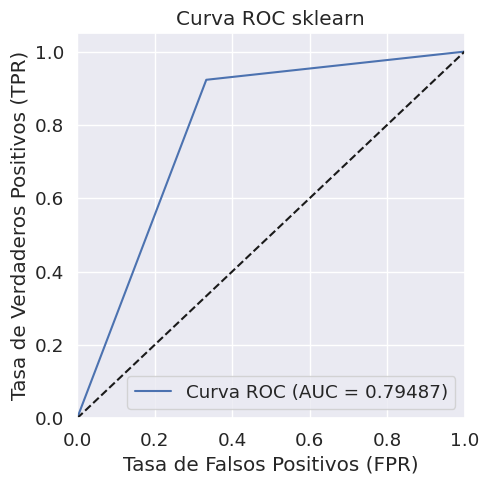

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_np, sklearn_tree_proba)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC sklearn')
plt.legend(loc="lower right")
plt.show()

## Regresión Lineal

### Conversión a NumPy arrays

In [766]:
X_test_np = X_test_clean_linear.to_numpy()
y_test_np = y_test_clean_linear.to_numpy()

X_train_np = X_train_clean_linear.to_numpy()
y_train_np = y_train_clean_linear.to_numpy()

### Entrenamiento

In [775]:
our_linear_reg = OurLinearRegression(lr=0.15, num_iter=1000)
our_linear_reg.fit(X_train_np, y_train_np)

### Testing

In [776]:
y_pred_linear = our_linear_reg.predict(X_test_np)
y_pred_linear_train = our_linear_reg.predict(X_train_np)

### Resultados

Los errores obtenidos no demuestran overfitting ni underfitting, ya que tanto para el entrenamiento como para el testeo se encuentran en valores similares.

In [777]:
mse = mean_squared_error(y_test_np, y_pred_linear)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_np, y_pred_linear)

mse_train = mean_squared_error(y_train_np, y_pred_linear_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_np, y_pred_linear_train)

print('Our train MSE:  {0:0.8f}'. format(mse_train))
print('Our train RMSE: {0:0.8f}'. format(rmse_train))
print('Our train MAE:  {0:0.8f}'. format(mae_train))
print("\n")
print('Our test MSE:  {0:0.8f}'. format(mse))
print('Our test RMSE: {0:0.8f}'. format(rmse))
print('Our test MAE:  {0:0.8f}'. format(mae))

Our train MSE:  210.17490260
Our train RMSE: 14.49741020
Our train MAE:  10.05946555


Our test MSE:  174.46076784
Our test RMSE: 13.20835977
Our test MAE:  9.71331634


### Ajuste de Hiperparámetros

In [774]:
def objective(trial):
    lr = trial.suggest_float('lr', 0.01, 0.5, log=True)
    num_iter = trial.suggest_int('num_iter', 20000, 300000)

    model = OurLinearRegression(lr=lr, num_iter=num_iter)

    model.fit(X_train_np, y_train_np)

    y_pred = model.predict(X_test_np)

    # métrica a optimizar
    mse = mean_squared_error(y_test_np, y_pred)
    rmse = np.sqrt(mse)

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

best_params = study.best_params
best_recall_score = study.best_value

[I 2023-10-04 04:51:13,195] A new study created in memory with name: no-name-cdbbcfe7-ef39-40c4-9bca-96d38cee738e
[I 2023-10-04 04:51:15,600] Trial 0 finished with value: 13.208359770961227 and parameters: {'lr': 0.05527879113202277, 'num_iter': 67861}. Best is trial 0 with value: 13.208359770961227.
[I 2023-10-04 04:51:20,509] Trial 1 finished with value: 13.208359770961206 and parameters: {'lr': 0.2833397994617121, 'num_iter': 156989}. Best is trial 1 with value: 13.208359770961206.
[I 2023-10-04 04:51:21,195] Trial 2 finished with value: 13.208359770961215 and parameters: {'lr': 0.10391304557933573, 'num_iter': 22614}. Best is trial 1 with value: 13.208359770961206.
[I 2023-10-04 04:51:31,592] Trial 3 finished with value: 13.208359770961206 and parameters: {'lr': 0.38828028551432703, 'num_iter': 268543}. Best is trial 1 with value: 13.208359770961206.
[I 2023-10-04 04:51:36,804] Trial 4 finished with value: 13.208359770961227 and parameters: {'lr': 0.05175937327257193, 'num_iter': 2

### Resultados finales

In [781]:
our_linear_reg = OurLinearRegression(lr=best_params['lr'], num_iter=best_params['num_iter'])
our_linear_reg.fit(X_train_np, y_train_np)
y_pred_linear = our_linear_reg.predict(X_test_np)

In [782]:
mse = mean_squared_error(y_test_np, y_pred_linear)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_np, y_pred_linear)

print('Our MSE:  {0:0.8f}'. format(mse))
print('Our RMSE: {0:0.8f}'. format(rmse))
print('Our MAE:  {0:0.8f}'. format(mae))

Our MSE:  174.46076784
Our RMSE: 13.20835977
Our MAE:  9.71331634


### Comparación con sklearn

In [783]:
sklearn_linear = LinearRegression()
sklearn_linear.fit(X_train_np, y_train_np)
sklearn_linear_pred = sklearn_linear.predict(X_test_np)

mse = mean_squared_error(y_test_np, sklearn_linear_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_np, sklearn_linear_pred)

print('sklearn MSE:  {0:0.8f}'. format(mse))
print('sklearn RMSE: {0:0.8f}'. format(rmse))
print('sklearn MAE:  {0:0.8f}'. format(mae))

sklearn MSE:  174.46076784
sklearn RMSE: 13.20835977
sklearn MAE:  9.71331634


# Titanic

## Feature Engineering

### Información descriptiva del dataset

In [253]:
data_titanic = pd.read_csv("https://raw.githubusercontent.com/danib08/Datasets-Patrones/main/Titanic-Dataset.csv")
data_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Significado de cada feature**
1. **PassengerId**: unique id number to each passenger
2. **Survived**: wether survived or not: 0 = No, 1 = Yes
3. **Pclass**: ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
4. **Name**: name of the passenger
5. **Sex**: gender
6. **Age**: age in years
7. **SibSp**: no. of siblings / spouses aboard the Titanic
8. **Parch**: no. of parents / children aboard the Titanic
9. **Ticket**: ticket number
10. **Fare**: passenger fare
11. **Cabin**: Cabin number
12. **Embarked**: port of embarkation:C = Cherbourg, Q = Queenstown, S = Southampton



In [254]:
data_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


El dataset contiene dos features categóricas, Sex y Embarked, por lo que estas deberán transformarse.

In [255]:
data_titanic.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

De primera entrada, se observa que el dataset cuenta con 891 muestras, y las features PassengerId y Name poseen la misma cantidad de valores únicos, ya que son valores específicos por pasajero.

Para la feature Ticket, se tienen 681 valores únicos, lo que es también una gran cantidad.

Para Cabin, tiene 204 valores no nulos, de los cuales 147 son únicos, lo que quiere decir que la gran mayoría de información de esta feature no se tiene, y rellenarla podría ser más bien contraproducente.

Estas features serán eliminadas por tener verdadero valor para el modelo.

In [256]:
data_titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
data_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


Las features con valores nulos son Age y Embarked, lo que deberá arreglarse. No hay targets (Survived) nulos.

### Visualización del Sesgo

Se observa un sesgo considerable en el dataset, lo que deberá corregirse.

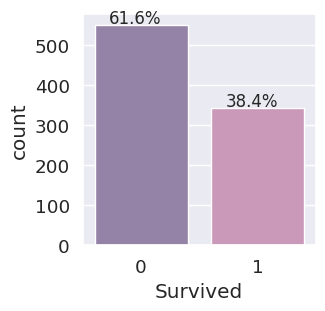

In [257]:
colors= ["#957DAD","#D291BC"]
plt.figure(figsize=(3, 3))
ax = sns.countplot(x=data_titanic["Survived"], palette=colors)

total = len(data_titanic["Survived"])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height() + 5
    ax.annotate(percentage, (x, y), fontsize=12, ha='center')

plt.show()

### División en sets de Training / Test

In [258]:
target = data_titanic['Survived']
features = data_titanic.drop(['Survived'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=43, stratify=target)

### Valores nulos - Variables numéricas

In [259]:
# variables numéricas
null_categorical = ["Age"]

# reemplazar nulos por mediana de columna respectiva
X_train[null_categorical] = imputer_median.fit_transform(X_train[null_categorical])
X_test[null_categorical] = imputer_median.transform(X_test[null_categorical])

# visualizar total de valores nulos
null_counts = X_train[null_categorical].apply(lambda x: x.isnull().sum())
print(null_counts)

Age    0
dtype: int64


### Valores nulos - Variables categóricas

In [260]:
# variables categóricas
null_categorical = ["Embarked"]

# reemplazar nulos por moda de columna respectiva
X_train[null_categorical] = imputer_mode.fit_transform(X_train[null_categorical])
X_test[null_categorical] = imputer_mode.transform(X_test[null_categorical])

# visualizar total de valores nulos
null_counts = X_train[null_categorical].apply(lambda x: x.isnull().sum())
print(null_counts)

Embarked    0
dtype: int64


### Encoding de strings a valores numéricos

In [261]:
# variables categóricas
objs = (X_train.dtypes == "object")
categories = list(objs[objs].index)

label_encoder = LabelEncoder()

combined_data = pd.concat([X_train, X_test], axis=0)
combined_data[categories] = combined_data[categories].apply(lambda col: label_encoder.fit_transform(col))

X_train = combined_data.iloc[:len(X_train)]
X_test = combined_data.iloc[len(X_train):]

X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 234 to 22
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    int64  
 2   Age       712 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Embarked  712 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 44.5 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 876 to 201
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    179 non-null    int64  
 1   Sex       179 non-null    int64  
 2   Age       179 non-null    float64
 3   SibSp     179 non-null    int64  
 4   Parch     179 non-null    int64  
 5   Fare      179 non-null    float64
 6   Embarked  179 non-null    int64  
dtypes: float64(2), int64(5)
memory 

### Normalización

In [262]:
# reset indices so StandardScaler doesn't mismatch them
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

s_scaler = StandardScaler()

col_names = list(combined_data.columns)

X_train = s_scaler.fit_transform(X_train)
X_test = s_scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=col_names)
X_test = pd.DataFrame(X_test, columns=col_names)

indices_match = X_train.index.equals(y_train.index) and X_test.index.equals(y_test.index)

if indices_match:
    print("Indices match.")
else:
    print("Indices do not match.")

Indices match.


### Análisis de Outliers / Caja de Bigotes

Se eliminarán outliers para las features Age, SibSp, Parch y Fare.

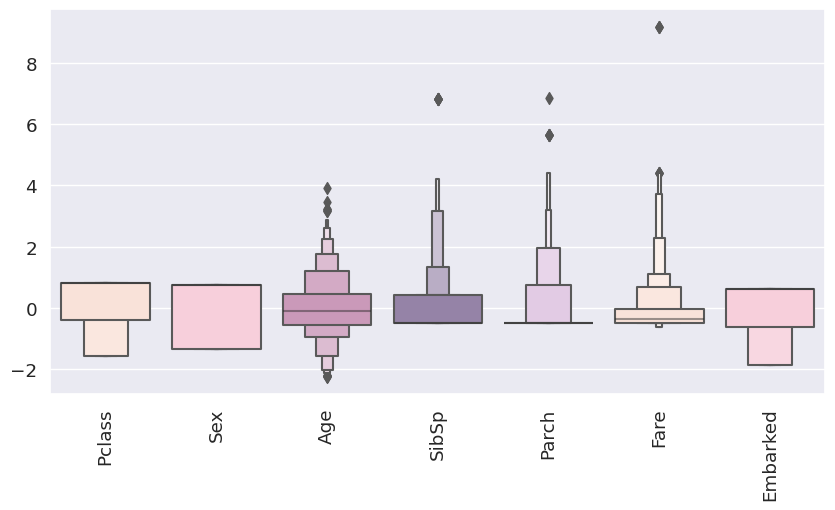

In [263]:
combined_data = pd.concat([X_train, X_test], axis=0)

colors = ["#FFDFD3", "#FEC8D8", "#D291BC", "#957DAD", "#E0BBE4"]
plt.figure(figsize=(10,5))
sns.boxenplot(data = combined_data, palette = colors)
plt.xticks(rotation=90)
plt.show()

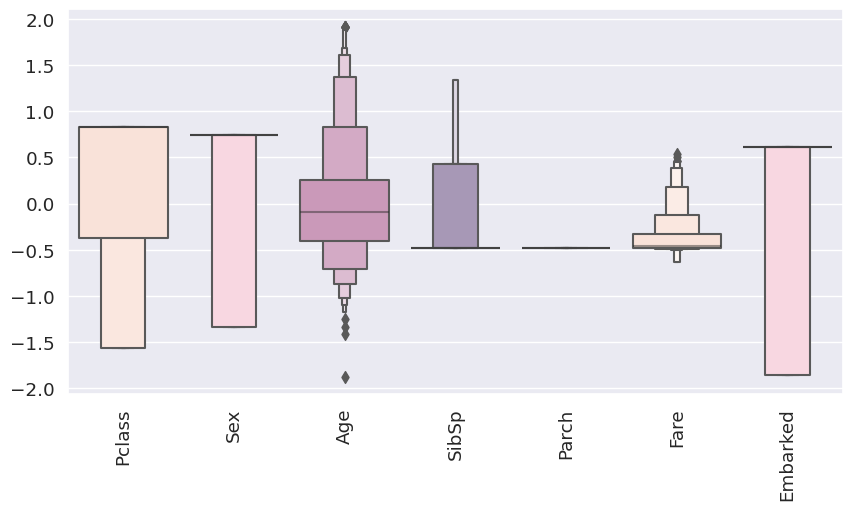

In [264]:
# funcion para eliminar outliers
def remove_outliers(dataframe, X_train, X_test, y_train, y_test, column, multiplier=1.5):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_fence = Q1 - (IQR * multiplier)
    upper_fence = Q3 + (IQR * multiplier)

    mask_train = (X_train[column] >= lower_fence) & (X_train[column] <= upper_fence)
    mask_test = (X_test[column] >= lower_fence) & (X_test[column] <= upper_fence)

    cleaned_X_train = X_train[mask_train]
    cleaned_X_test = X_test[mask_test]

    cleaned_y_train = y_train[mask_train]
    cleaned_y_test = y_test[mask_test]

    return cleaned_X_train, cleaned_X_test, cleaned_y_train, cleaned_y_test

# features en las cuales se eliminaran outliers
features_to_remove_outliers = ['Age', 'SibSp', 'Parch', 'Fare']

X_train_clean = X_train.copy()
X_test_clean = X_test.copy()
y_train_clean = y_train.copy()
y_test_clean = y_test.copy()

for feature in features_to_remove_outliers:
     X_train_clean, X_test_clean, y_train_clean, y_test_clean = remove_outliers(combined_data, X_train_clean, X_test_clean, y_train_clean, y_test_clean, feature)

combined_data_clean = pd.concat([X_train_clean, X_test_clean], axis=0)
plt.figure(figsize=(10,5))
sns.boxenplot(data = combined_data_clean, palette = colors)
plt.xticks(rotation=90)
plt.show()

### Matriz de correlación

Se observa que no hay variables altamente correlacionadas, por lo que no se deben eliminar features.

<Axes: >

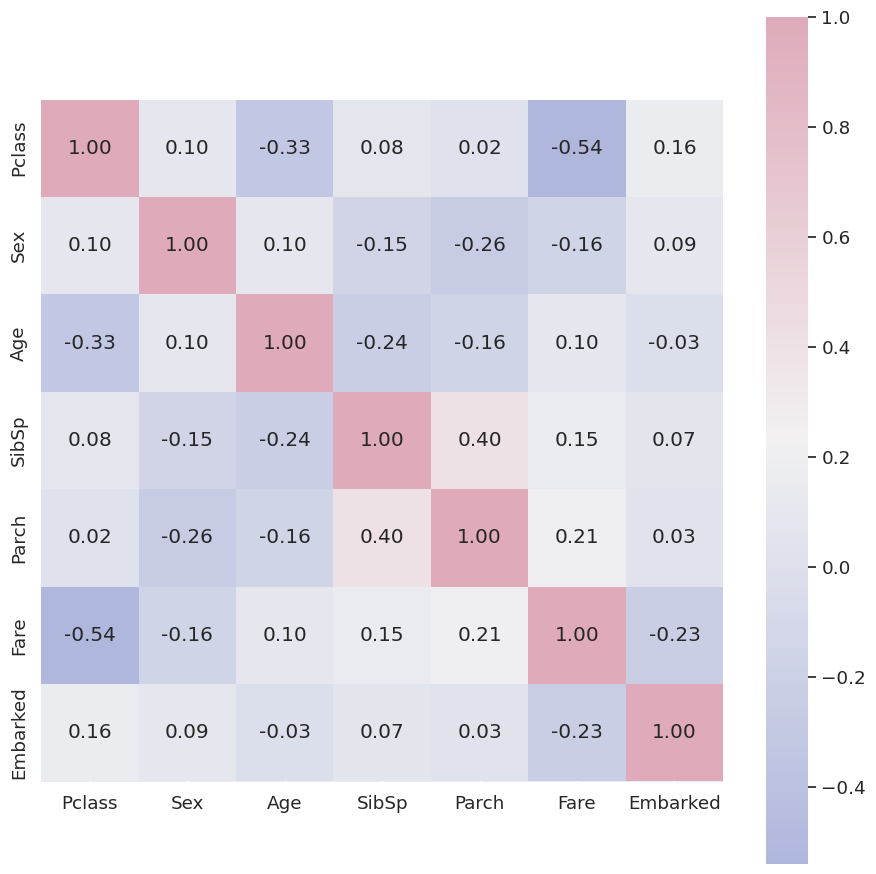

In [265]:
corrmat = X_train.corr(numeric_only=True)
cmap = sns.diverging_palette(260, -10, s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(11,11))
sns.heatmap(corrmat, cmap=cmap, annot=True, square=True, fmt='.2f')

### Reducción del sesgo

In [266]:
smote = SMOTE(random_state=45)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

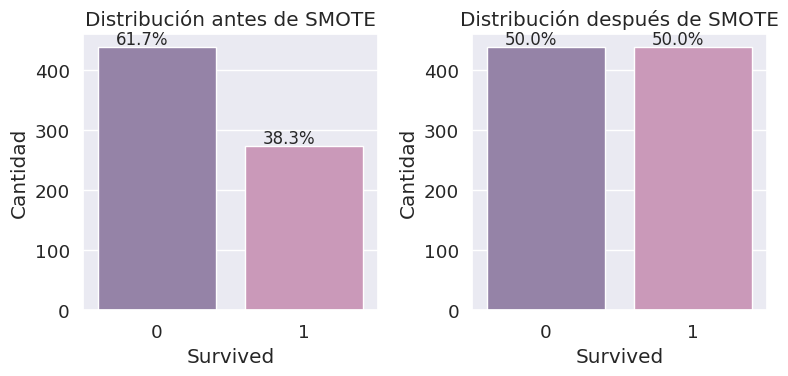

In [267]:
colors= ["#957DAD","#D291BC"]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette=colors)
plt.title("Distribución antes de SMOTE")
plt.xlabel("Survived")
plt.ylabel("Cantidad")

total_before = len(y_train)
for p in plt.gca().patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_before)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_height() + 5
    plt.annotate(percentage, (x, y), fontsize=12, ha='center')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled, palette=colors)
plt.title("Distribución después de SMOTE")
plt.xlabel("Survived")
plt.ylabel("Cantidad")

total_after = len(y_train_resampled)
for p in plt.gca().patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_after)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_height() + 5
    plt.annotate(percentage, (x, y), fontsize=12, ha='center')

plt.tight_layout()
plt.show()

## Regresión Logística

### Entrenamiento

Se entrenarán dos modelos, uno con el dataset sin sesgo y otro con sesgo. Esto para mostrar las diferencias en métricas en ambos casos.

In [268]:
# con sesgo
our_logreg = OurLogisticRegression(0.15, 20000)
our_logreg.fit(X_train, y_train)

# sin sesgo
our_logreg_balanced = OurLogisticRegression(0.15, 20000)
our_logreg_balanced.fit(X_train_resampled, y_train_resampled)

### Testing

In [269]:
# con sesgo
y_pred_logreg = our_logreg.predict(X_test, threshold=0.5)
y_pred_train_logreg = our_logreg.predict(X_train, threshold=0.5)
y_prob_logreg = our_logreg.predict_prob(X_test)

# sin sesgo
y_pred_logreg_balanced = our_logreg_balanced.predict(X_test, threshold=0.5)
y_pred_train_logreg_balanced = our_logreg_balanced.predict(X_train_resampled, threshold=0.5)
y_prob_logreg_balanced = our_logreg_balanced.predict_prob(X_test)

### Métricas y Análisis Inicial

Se obtiene mejores métricas con el dataset sin sesgo, por lo que se seguirá utilizando este.

In [252]:
# accuracy, precision, recall, f1

# con sesgo
our_logreg_train_accuracy = accuracy_score(y_train, y_pred_train_logreg)
our_logreg_train_precision = precision_score(y_train, y_pred_train_logreg)
our_logreg_train_recall = recall_score(y_train, y_pred_train_logreg)
our_logreg_train_f1 = f1_score(y_train, y_pred_train_logreg)

our_logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
our_logreg_precision = precision_score(y_test, y_pred_logreg)
our_logreg_recall = recall_score(y_test, y_pred_logreg)
our_logreg_f1 = f1_score(y_test, y_pred_logreg)

# sin sesgo
our_logreg_train_accuracy_balanced = accuracy_score(y_train_resampled, y_pred_train_logreg_balanced)
our_logreg_train_precision_balanced = precision_score(y_train_resampled, y_pred_train_logreg_balanced)
our_logreg_train_recall_balanced = recall_score(y_train_resampled, y_pred_train_logreg_balanced)
our_logreg_train_f1_balanced = f1_score(y_train_resampled, y_pred_train_logreg_balanced)

our_logreg_accuracy_balanced = accuracy_score(y_test, y_pred_logreg_balanced)
our_logreg_precision_balanced = precision_score(y_test, y_pred_logreg_balanced)
our_logreg_recall_balanced = recall_score(y_test, y_pred_logreg_balanced)
our_logreg_f1_balanced = f1_score(y_test, y_pred_logreg_balanced)

print("----- DATASET CON SESGO -----")
print('Our training accuracy:  {0:0.8f}'. format(our_logreg_train_accuracy))
print('Our training precision: {0:0.8f}'. format(our_logreg_train_precision))
print('Our training recall:    {0:0.8f}'. format(our_logreg_train_recall))
print('Our training F1:        {0:0.8f}'. format(our_logreg_train_f1))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_logreg_accuracy))
print('Our test precision: {0:0.8f}'. format(our_logreg_precision))
print('Our test recall:    {0:0.8f}'. format(our_logreg_recall))
print('Our test F1:        {0:0.8f}'. format(our_logreg_f1))
print("\n")

print("----- DATASET SIN SESGO -----")
print('Our training accuracy:  {0:0.8f}'. format(our_logreg_train_accuracy_balanced))
print('Our training precision: {0:0.8f}'. format(our_logreg_train_precision_balanced))
print('Our training recall:    {0:0.8f}'. format(our_logreg_train_recall_balanced))
print('Our training F1:        {0:0.8f}'. format(our_logreg_train_f1_balanced))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_logreg_accuracy_balanced))
print('Our test precision: {0:0.8f}'. format(our_logreg_precision_balanced))
print('Our test recall:    {0:0.8f}'. format(our_logreg_recall_balanced))
print('Our test F1:        {0:0.8f}'. format(our_logreg_f1_balanced))

----- DATASET CON SESGO -----
Our training accuracy:  0.79775281
Our training precision: 0.75903614
Our training recall:    0.69230769
Our training F1:        0.72413793


Our test accuracy:  0.82122905
Our test precision: 0.79365079
Our test recall:    0.72463768
Our test F1:        0.75757576


----- DATASET SIN SESGO -----
Our training accuracy:  0.78018223
Our training precision: 0.79285714
Our training recall:    0.75854214
Our training F1:        0.77532014


Our test accuracy:  0.83240223
Our test precision: 0.79104478
Our test recall:    0.76811594
Our test F1:        0.77941176


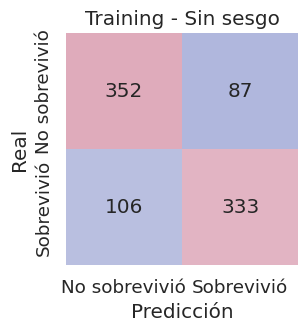

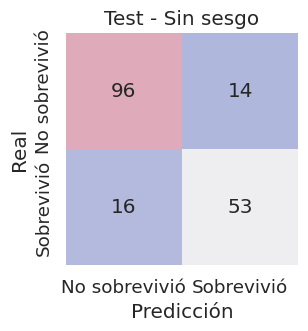

In [270]:
# confusion matrix
cm_train = confusion_matrix(y_train_resampled, y_pred_train_logreg_balanced)
cm_test = confusion_matrix(y_test, y_pred_logreg_balanced)

class_names = ["No sobrevivió", "Sobrevivió"]

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 5))
sns.heatmap(cm_train, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Training - Sin sesgo')
plt.show()

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Test - Sin sesgo')
plt.show()

La curva ROC obtenida es algo extraña en su forma, sin embargo, el valor obtenido en AUC es muy bueno.

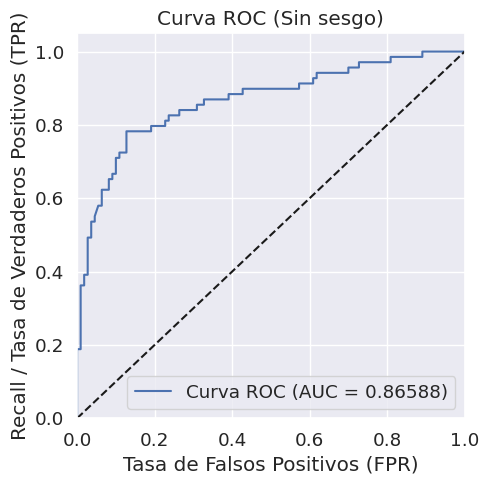

In [271]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg_balanced)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC (Sin sesgo)')
plt.legend(loc="lower right")
plt.show()

### Ajuste de Hiperparámetros

In [272]:
def objective(trial):
    lr = trial.suggest_float('lr', 0.01, 0.5, log=True)
    num_iter = trial.suggest_int('num_iter', 20000, 200000)

    model = OurLogisticRegression(lr=lr, num_iter=num_iter)

    model.fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_test, threshold=0.5)

    # métrica a optimizar
    F1 = f1_score(y_test, y_pred)

    return F1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

best_params = study.best_params
best_recall_score = study.best_value

[I 2023-10-03 22:54:28,024] A new study created in memory with name: no-name-d440b201-7484-4ffc-ae10-e90b13e750a6
[I 2023-10-03 22:55:10,852] Trial 0 finished with value: 0.7794117647058824 and parameters: {'lr': 0.011229770417227699, 'num_iter': 150480}. Best is trial 0 with value: 0.7794117647058824.
[I 2023-10-03 22:55:48,935] Trial 1 finished with value: 0.7794117647058824 and parameters: {'lr': 0.1343907637463076, 'num_iter': 185022}. Best is trial 0 with value: 0.7794117647058824.
[I 2023-10-03 22:55:56,374] Trial 2 finished with value: 0.7794117647058824 and parameters: {'lr': 0.36966045818294213, 'num_iter': 40263}. Best is trial 0 with value: 0.7794117647058824.
[I 2023-10-03 22:56:47,601] Trial 3 finished with value: 0.7794117647058824 and parameters: {'lr': 0.3684433636748341, 'num_iter': 134553}. Best is trial 0 with value: 0.7794117647058824.
[I 2023-10-03 22:57:31,453] Trial 4 finished with value: 0.7794117647058824 and parameters: {'lr': 0.4691254769755712, 'num_iter': 1

### Resultados finales - Ajuste de Umbral

Por último, se probarán distintos umbrales para mejorar el F1 score.

In [273]:
our_logreg = OurLogisticRegression(best_params['lr'], best_params['num_iter'])
our_logreg.fit(X_train_resampled, y_train_resampled)
y_prob_logreg = our_logreg.predict_prob(X_test)

# umbrales a probar
thresholds = np.linspace(0, 1, 101)
best_threshold = 0
best_f1 = 0

for threshold in thresholds:
    y_pred = (y_prob_logreg > threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

y_pred_best = (y_prob_logreg > best_threshold).astype(int)

# accuracy, precision, recall, f1
our_logreg_reg_accuracy = accuracy_score(y_test, y_pred_best)
our_logreg_reg_precision = precision_score(y_test, y_pred_best)
our_logreg_reg_recall = recall_score(y_test, y_pred_best)
our_logreg_reg_f1 = f1_score(y_test, y_pred_best)

print('Our accuracy:  {0:0.8f}'. format(our_logreg_reg_accuracy))
print('Our precision: {0:0.8f}'. format(our_logreg_reg_precision))
print('Our recall:    {0:0.8f}'. format(our_logreg_reg_recall))
print('Our F1:        {0:0.8f}'. format(our_logreg_reg_f1))

Our accuracy:  0.83798883
Our precision: 0.79411765
Our recall:    0.78260870
Our F1:        0.78832117


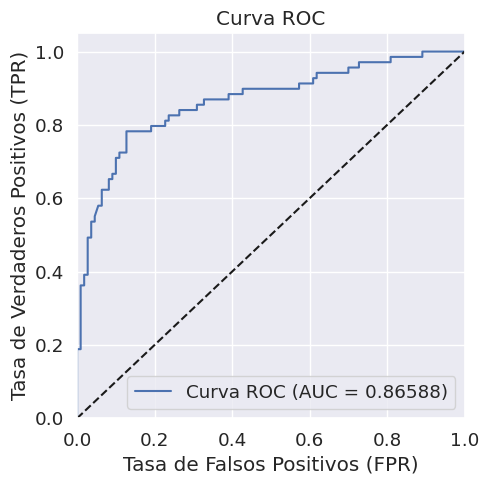

In [274]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Comparación de sklearn

In [275]:
skleran_logreg = LogisticRegression(random_state=42)
skleran_logreg.fit(X_train_resampled, y_train_resampled)
skleran_logreg_pred = skleran_logreg.predict(X_test)
sklearn_y_proba = skleran_logreg.predict_proba(X_test)[:, 1]

sklearn_logreg_accuracy = accuracy_score(y_test, skleran_logreg_pred)
sklearn_logreg_precision = precision_score(y_test, skleran_logreg_pred)
sklearn_logreg_recall = recall_score(y_test, skleran_logreg_pred)
sklearn_logreg_f1 = f1_score(y_test, skleran_logreg_pred)

print('sklearn accuracy:  {0:0.8f}'. format(sklearn_logreg_accuracy))
print('sklearn precision: {0:0.8f}'. format(sklearn_logreg_precision))
print('sklearn recall:    {0:0.8f}'. format(sklearn_logreg_recall))
print('sklearn F1:        {0:0.8f}'. format(sklearn_logreg_f1))

sklearn accuracy:  0.83240223
sklearn precision: 0.79104478
sklearn recall:    0.76811594
sklearn F1:        0.77941176


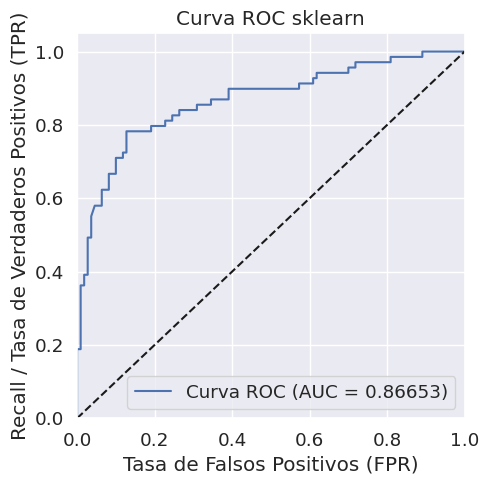

In [276]:
fpr, tpr, thresholds = roc_curve(y_test, sklearn_y_proba)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC sklearn')
plt.legend(loc="lower right")
plt.show()

## K-Nearest Neighbors

### Conversión a NumPy arrays

In [277]:
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

X_train_np = X_train_resampled.to_numpy()
y_train_np = y_train_resampled.to_numpy()

### Entrenamiento

In [301]:
our_knn = OurKNearest(X_train_np, y_train_np, n_neighbors=5, weights='distance', n_classes=2, distance='minkowski', p=0.6)

### Testing

In [302]:
y_pred_knn_train = our_knn.predict(X_train_np, return_prob=False)
y_pred_knn, y_prob_knn = our_knn.predict(X_test_np)

### Métricas y Análisis Inicial

Incialmente, se presenta overfitting en el modelo.

In [303]:
our_knn_accuracy_train = accuracy_score(y_train_np, y_pred_knn_train)
our_knn_precision_train = precision_score(y_train_np, y_pred_knn_train)
our_knn_recall_train = recall_score(y_train_np, y_pred_knn_train)
our_knn_f1_train = f1_score(y_train_np, y_pred_knn_train)

our_knn_accuracy = accuracy_score(y_test_np, y_pred_knn)
our_knn_precision = precision_score(y_test_np, y_pred_knn)
our_knn_recall = recall_score(y_test_np, y_pred_knn)
our_knn_f1 = f1_score(y_test_np, y_pred_knn)

print('Our train accuracy:  {0:0.8f}'. format(our_knn_accuracy_train))
print('Our train precision: {0:0.8f}'. format(our_knn_precision_train))
print('Our train recall:    {0:0.8f}'. format(our_knn_recall_train))
print('Our train F1:        {0:0.8f}'. format(our_knn_f1_train))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_knn_accuracy))
print('Our test precision: {0:0.8f}'. format(our_knn_precision))
print('Our test recall:    {0:0.8f}'. format(our_knn_recall))
print('Our test F1:        {0:0.8f}'. format(our_knn_f1))

Our train accuracy:  0.85535308
Our train precision: 0.86111111
Our train recall:    0.84738041
Our train F1:        0.85419059


Our test accuracy:  0.75418994
Our test precision: 0.66666667
Our test recall:    0.72463768
Our test F1:        0.69444444


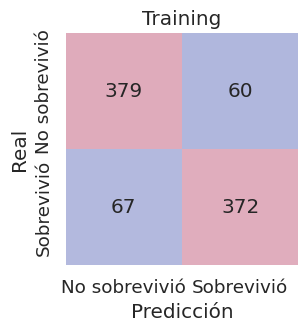

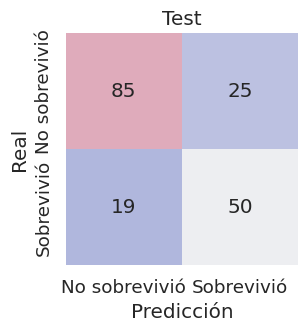

In [304]:
# confusion matrix
cm_train = confusion_matrix(y_train_np, y_pred_knn_train)
cm_test = confusion_matrix(y_test_np, y_pred_knn)

class_names = ["No sobrevivió", "Sobrevivió"]

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 5))
sns.heatmap(cm_train, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Training')
plt.show()

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Test')
plt.show()

El valor AUC inicial no es aceptable para un buen modelo.

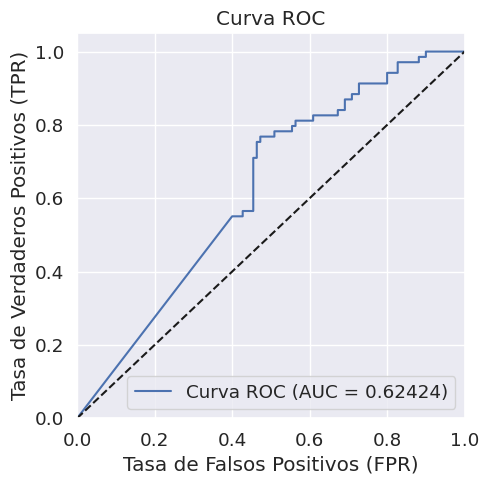

In [305]:
fpr, tpr, thresholds = roc_curve(y_test_np, y_prob_knn[:, 1])
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Ajuste de Hiperparámetro (k)

In [306]:
def objective(trial):
    k = trial.suggest_int('k', 5, 100)

    model = OurKNearest(X_train_np, y_train_np, n_neighbors=k, weights='distance', n_classes=2, distance='minkowski', p=0.6)
    y_pred = our_knn.predict(X_test_np, return_prob=False)

    # métrica a optimizar
    F1 = f1_score(y_test_np, y_pred)

    return F1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_recall_score = study.best_value

[I 2023-10-03 23:12:28,075] A new study created in memory with name: no-name-198e930c-e407-4706-9a79-1a9ce70b3022
[I 2023-10-03 23:12:28,209] Trial 0 finished with value: 0.6944444444444444 and parameters: {'k': 69}. Best is trial 0 with value: 0.6944444444444444.
[I 2023-10-03 23:12:28,306] Trial 1 finished with value: 0.6944444444444444 and parameters: {'k': 15}. Best is trial 0 with value: 0.6944444444444444.
[I 2023-10-03 23:12:28,381] Trial 2 finished with value: 0.6944444444444444 and parameters: {'k': 74}. Best is trial 0 with value: 0.6944444444444444.
[I 2023-10-03 23:12:28,463] Trial 3 finished with value: 0.6944444444444444 and parameters: {'k': 42}. Best is trial 0 with value: 0.6944444444444444.
[I 2023-10-03 23:12:28,636] Trial 4 finished with value: 0.6944444444444444 and parameters: {'k': 15}. Best is trial 0 with value: 0.6944444444444444.
[I 2023-10-03 23:12:28,838] Trial 5 finished with value: 0.6944444444444444 and parameters: {'k': 32}. Best is trial 0 with value: 

### Resultados finales

Con el hiperparámetro k ajustado, se resolvió el overfitting y también se mejoró en gran medida el valor de AUC.

In [307]:
our_knn = OurKNearest(X_train_np, y_train_np, n_neighbors=best_params['k'], weights='distance', n_classes=2, distance='minkowski', p=0.7)

y_pred_knn_train = our_knn.predict(X_train_np, return_prob=False)
y_pred_knn, y_prob_knn = our_knn.predict(X_test_np)

In [308]:
our_knn_accuracy_train = accuracy_score(y_train_np, y_pred_knn_train)
our_knn_precision_train = precision_score(y_train_np, y_pred_knn_train)
our_knn_recall_train = recall_score(y_train_np, y_pred_knn_train)
our_knn_f1_train = f1_score(y_train_np, y_pred_knn_train)

our_knn_accuracy = accuracy_score(y_test_np, y_pred_knn)
our_knn_precision = precision_score(y_test_np, y_pred_knn)
our_knn_recall = recall_score(y_test_np, y_pred_knn)
our_knn_f1 = f1_score(y_test_np, y_pred_knn)


print('Our train accuracy:  {0:0.8f}'. format(our_knn_accuracy_train))
print('Our train precision: {0:0.8f}'. format(our_knn_precision_train))
print('Our train recall:    {0:0.8f}'. format(our_knn_recall_train))
print('Our train F1:        {0:0.8f}'. format(our_knn_f1_train))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_knn_accuracy))
print('Our test precision: {0:0.8f}'. format(our_knn_precision))
print('Our test recall:    {0:0.8f}'. format(our_knn_recall))
print('Our test F1:        {0:0.8f}'. format(our_knn_f1))

Our train accuracy:  0.77107062
Our train precision: 0.77934272
Our train recall:    0.75626424
Our train F1:        0.76763006


Our test accuracy:  0.79888268
Our test precision: 0.72602740
Our test recall:    0.76811594
Our test F1:        0.74647887


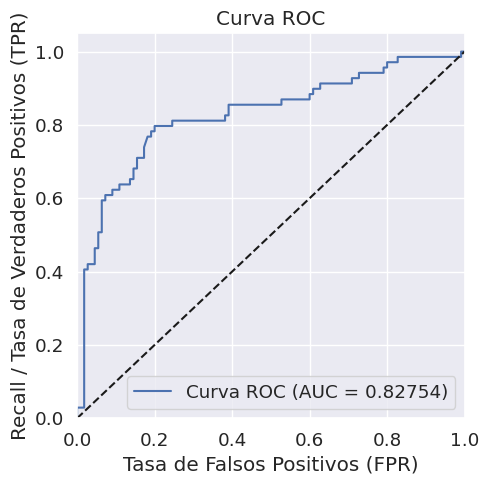

In [309]:
fpr, tpr, thresholds = roc_curve(y_test_np, y_prob_knn[:, 1])
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Comparación con sklearn

In [310]:
sklearn_knn = KNeighborsClassifier(n_neighbors=best_params['k'], weights='distance')
sklearn_knn.fit(X_train_np, y_train_np)
skleran_knn_pred = sklearn_knn.predict(X_test_np)
sklearn_knn_proba = sklearn_knn.predict_proba(X_test_np)[:, 1]

sklearn_knn_accuracy = accuracy_score(y_test_np, skleran_knn_pred)
sklearn_knn_precision = precision_score(y_test_np, skleran_knn_pred)
sklearn_knn_recall = recall_score(y_test_np, skleran_knn_pred)
sklearn_knn_f1 = f1_score(y_test_np, skleran_knn_pred)

print('sklearn accuracy:  {0:0.8f}'. format(sklearn_knn_accuracy))
print('sklearn precision: {0:0.8f}'. format(sklearn_knn_precision))
print('sklearn recall:    {0:0.8f}'. format(sklearn_knn_recall))
print('sklearn F1:        {0:0.8f}'. format(sklearn_knn_f1))

sklearn accuracy:  0.81564246
sklearn precision: 0.75714286
sklearn recall:    0.76811594
sklearn F1:        0.76258993


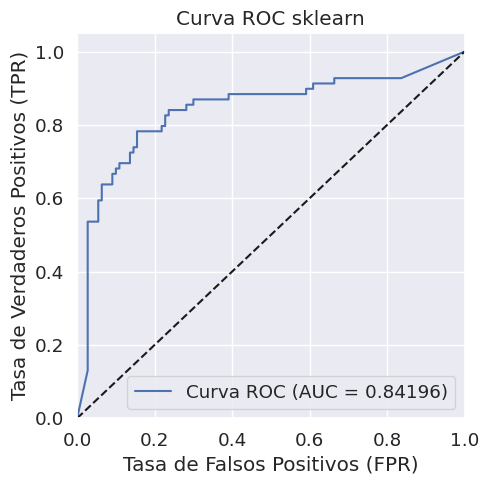

In [311]:
fpr, tpr, thresholds = roc_curve(y_test_np, sklearn_knn_proba)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC sklearn')
plt.legend(loc="lower right")
plt.show()

## Árboles de decisión

### Entrenamiento

In [312]:
tree = Node(max_depth=5)
tree.fit(X_train_np, y_train_np)

### Testing

In [313]:
y_pred_tree = []
for X in X_test_np:
    y_pred_individual = tree.predict(X)
    y_pred_tree.append(y_pred_individual)

y_pred_tree = np.array(y_pred_tree)
y_prob_tree = tree.predict_prob(X_test_np)

y_pred_tree_train = []
for X in X_train_np:
    y_pred_individual = tree.predict(X)
    y_pred_tree_train.append(y_pred_individual)

y_pred_tree_train = np.array(y_pred_tree_train)

### Métricas y Análisis Inicial

Las métricas obtenidas son buenas. El overfitting observado es muy poco.

In [314]:
our_tree_accuracy_train = accuracy_score(y_train_np, y_pred_tree_train)
our_tree_precision_train = precision_score(y_train_np, y_pred_tree_train)
our_tree_recall_train = recall_score(y_train_np, y_pred_tree_train)
our_tree_f1_train = f1_score(y_train_np, y_pred_tree_train)

our_tree_accuracy = accuracy_score(y_test_np, y_pred_tree)
our_tree_precision = precision_score(y_test_np, y_pred_tree)
our_tree_recall = recall_score(y_test_np, y_pred_tree)
our_tree_f1 = f1_score(y_test_np, y_pred_tree)

print('Our train accuracy:  {0:0.8f}'. format(our_tree_accuracy_train))
print('Our train precision: {0:0.8f}'. format(our_tree_precision_train))
print('Our train recall:    {0:0.8f}'. format(our_tree_recall_train))
print('Our train F1:        {0:0.8f}'. format(our_tree_f1_train))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_tree_accuracy))
print('Our test precision: {0:0.8f}'. format(our_tree_precision))
print('Our test recall:    {0:0.8f}'. format(our_tree_recall))
print('Our test F1:        {0:0.8f}'. format(our_tree_f1))

Our train accuracy:  0.84624146
Our train precision: 0.88974359
Our train recall:    0.79043280
Our train F1:        0.83715320


Our test accuracy:  0.81564246
Our test precision: 0.77272727
Our test recall:    0.73913043
Our test F1:        0.75555556


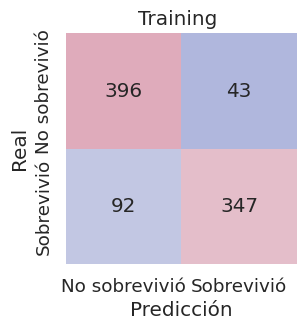

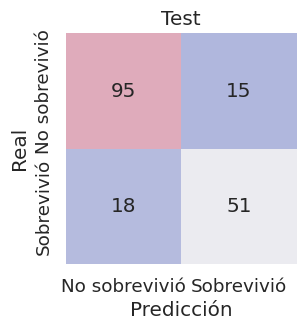

In [315]:
# confusion matrix
cm_train = confusion_matrix(y_train_np, y_pred_tree_train)
cm_test = confusion_matrix(y_test_np, y_pred_tree)

class_names = ["No sobrevivió", "Sobrevivió"]

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_train, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Training ')
plt.show()

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_test, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Test')
plt.show()

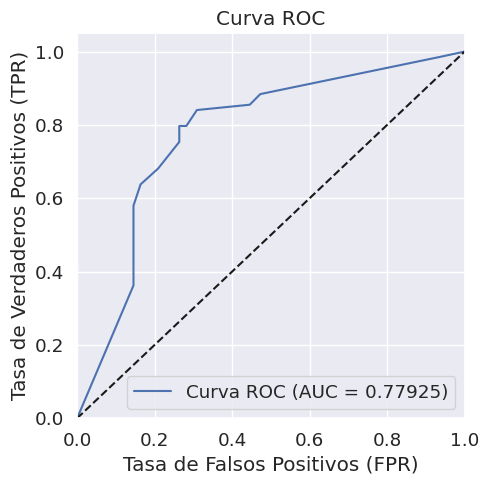

In [316]:
fpr, tpr, _ = roc_curve(y_test_np, y_prob_tree[:, 1])
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

### Ajuste de Hiperparámetro (profundidad)

Se ajustará el AUC al mejor valor posible.

In [324]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 8)

    tree = Node(max_depth=max_depth)
    tree.fit(X_train_np, y_train_np)

    y_prob_tree = tree.predict_prob(X_test_np)

    fpr, tpr, _ = roc_curve(y_test_np, y_prob_tree[:, 1])
    # métrica a optimizar
    roc_auc_curve = auc(fpr, tpr)

    return roc_auc_curve

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

best_params = study.best_params
best_recall_score = study.best_value

[I 2023-10-03 23:32:22,211] A new study created in memory with name: no-name-e0ee1b8d-069f-49d6-811a-bf7944ab8325
[I 2023-10-03 23:32:22,609] Trial 0 finished with value: 0.8831357048748353 and parameters: {'max_depth': 3}. Best is trial 0 with value: 0.8831357048748353.
[I 2023-10-03 23:32:23,291] Trial 1 finished with value: 0.7792490118577075 and parameters: {'max_depth': 5}. Best is trial 0 with value: 0.8831357048748353.
[I 2023-10-03 23:32:23,918] Trial 2 finished with value: 0.7792490118577075 and parameters: {'max_depth': 5}. Best is trial 0 with value: 0.8831357048748353.
[I 2023-10-03 23:32:24,424] Trial 3 finished with value: 0.8670619235836627 and parameters: {'max_depth': 4}. Best is trial 0 with value: 0.8831357048748353.
[I 2023-10-03 23:32:24,676] Trial 4 finished with value: 0.8178524374176549 and parameters: {'max_depth': 2}. Best is trial 0 with value: 0.8831357048748353.
[I 2023-10-03 23:32:25,073] Trial 5 finished with value: 0.8831357048748353 and parameters: {'ma

### Resultados finales

In [325]:
tree = Node(max_depth=best_params['max_depth'])
tree.fit(X_train_np, y_train_np)

y_pred_tree = []
for X in X_test_np:
    y_pred_individual = tree.predict(X)
    y_pred_tree.append(y_pred_individual)

y_pred_tree = np.array(y_pred_tree)
y_prob_tree = tree.predict_prob(X_test_np)

y_pred_tree_train = []
for X in X_train_np:
    y_pred_individual = tree.predict(X)
    y_pred_tree_train.append(y_pred_individual)

y_pred_tree_train = np.array(y_pred_tree_train)

In [326]:
our_tree_accuracy_train = accuracy_score(y_train_np, y_pred_tree_train)
our_tree_precision_train = precision_score(y_train_np, y_pred_tree_train)
our_tree_recall_train = recall_score(y_train_np, y_pred_tree_train)
our_tree_f1_train = f1_score(y_train_np, y_pred_tree_train)

our_tree_accuracy = accuracy_score(y_test_np, y_pred_tree)
our_tree_precision = precision_score(y_test_np, y_pred_tree)
our_tree_recall = recall_score(y_test_np, y_pred_tree)
our_tree_f1 = f1_score(y_test_np, y_pred_tree)

print('Our train accuracy:  {0:0.8f}'. format(our_tree_accuracy_train))
print('Our train precision: {0:0.8f}'. format(our_tree_precision_train))
print('Our train recall:    {0:0.8f}'. format(our_tree_recall_train))
print('Our train F1:        {0:0.8f}'. format(our_tree_f1_train))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_tree_accuracy))
print('Our test precision: {0:0.8f}'. format(our_tree_precision))
print('Our test recall:    {0:0.8f}'. format(our_tree_recall))
print('Our test F1:        {0:0.8f}'. format(our_tree_f1))

Our train accuracy:  0.82232346
Our train precision: 0.87139108
Our train recall:    0.75626424
Our train F1:        0.80975610


Our test accuracy:  0.82681564
Our test precision: 0.80645161
Our test recall:    0.72463768
Our test F1:        0.76335878


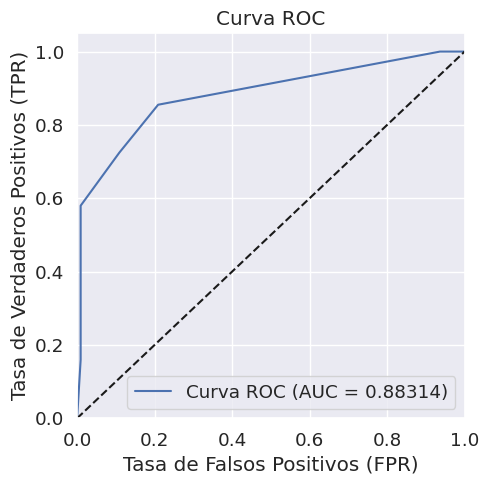

In [327]:
fpr, tpr, _ = roc_curve(y_test_np, y_prob_tree[:, 1])
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

### Comparación con sklearn

In [328]:
sklearn_tree = DecisionTreeClassifier(random_state=42)
sklearn_tree.fit(X_train_np, y_train_np)
skleran_tree_pred = sklearn_tree.predict(X_test_np)
sklearn_tree_proba = sklearn_tree.predict_proba(X_test_np)[:, 1]

sklearn_tree_accuracy = accuracy_score(y_test_np, skleran_tree_pred)
sklearn_tree_precision = precision_score(y_test_np, skleran_tree_pred)
sklearn_tree_recall = recall_score(y_test_np, skleran_tree_pred)
sklearn_tree_f1 = f1_score(y_test_np, skleran_tree_pred)

print('sklearn accuracy:  {0:0.8f}'. format(sklearn_tree_accuracy))
print('sklearn precision: {0:0.8f}'. format(sklearn_tree_precision))
print('sklearn recall:    {0:0.8f}'. format(sklearn_tree_recall))
print('sklearn F1:        {0:0.8f}'. format(sklearn_tree_f1))

sklearn accuracy:  0.78212291
sklearn precision: 0.69736842
sklearn recall:    0.76811594
sklearn F1:        0.73103448


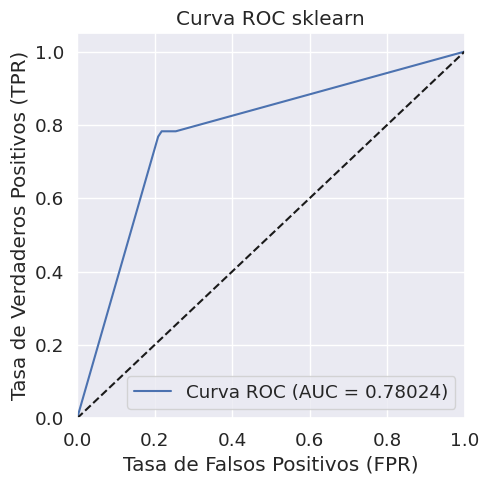

In [329]:
fpr, tpr, thresholds = roc_curve(y_test_np, sklearn_tree_proba)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC sklearn')
plt.legend(loc="lower right")
plt.show()